# Oxford Pets Dataset Classification
https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !unzip /content/drive/MyDrive/ece285_project/DataSets/UCMerced_LandUse.zip -d /content/drive/MyDrive/ece285_project/DataSets/

In [3]:
import os
import json
import time
import copy
from collections import Counter
import pickle

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split, Subset
# from torchvision.transforms import ToTensor, Resize
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

plt.ion()

import sys
sys.path.append('/content/drive/MyDrive/ece285_project/other_projects/SimCLR_v1/')
from models.resnet_simclr import ResNetSimCLR

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading Data

In [5]:
train_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

test_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

In [6]:
trainval_dataset = datasets.OxfordIIITPet(
    root="/content/drive/MyDrive/ece285_project/DataSets",
    split='trainval',
    download=True,
    transform=train_transforms
)

test_dataset = datasets.OxfordIIITPet(
    root="/content/drive/MyDrive/ece285_project/DataSets",
    split='test',
    download=True,
    transform=test_transforms
)

In [7]:
print(len(trainval_dataset))
print(len(test_dataset))

3680
3669


In [8]:
f = open(os.path.join(trainval_dataset._anns_folder, 'trainval.txt'), 'r')
trainval_targets = [int(x.split(' ')[1]) for x in f.readlines()]
print(Counter(trainval_targets))

Counter({1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 9: 100, 10: 100, 11: 100, 14: 100, 15: 100, 16: 100, 17: 100, 18: 100, 19: 100, 20: 100, 21: 100, 22: 100, 24: 100, 25: 100, 26: 100, 27: 100, 28: 100, 29: 100, 30: 100, 31: 100, 32: 100, 34: 100, 35: 100, 36: 100, 37: 100, 33: 99, 8: 96, 13: 96, 23: 96, 12: 93})


In [9]:
train_indices, test_indices, _, _ = train_test_split(
    range(len(trainval_dataset)),
    trainval_targets,
    stratify=trainval_targets,
    test_size=0.2,
    random_state=42
)

In [10]:
train_dataset = Subset(trainval_dataset, train_indices)
valid_dataset = Subset(trainval_dataset, test_indices)

In [11]:
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

2944
736
3669


In [12]:
datasets = {
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset,
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid', 'test']}

## PyTorch DataLoader

In [13]:
from torchvision.utils import make_grid

32


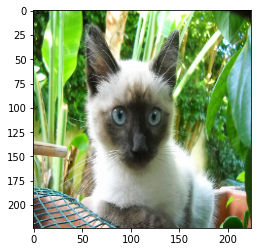

In [14]:
idx = np.random.choice(len(datasets['train']))

plt.imshow(torch.permute(datasets['train'][idx][0], (1,2,0)))
print(datasets['train'][idx][1])

In [15]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Training and Evaluate Pipeline

In [16]:
from tqdm import tqdm

In [17]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    metrics_dict = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # print(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
              metrics_dict['train_loss'].append(epoch_loss)
              metrics_dict['train_acc'].append(epoch_acc.item())
            else:
              metrics_dict['valid_loss'].append(epoch_loss)
              metrics_dict['valid_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics_dict

In [18]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # ax.set_title(f'predicted: {label_map_rev[preds[j].item()]}')
                plt.imshow(inputs.cpu().data[j].T)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
def evaluate_model(model, dataloader):

    running_corrects = 0

    model.eval()
    with torch.no_grad():

      # Iterate over data.
      for inputs, labels in dataloader:
          # print(inputs)
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          # statistics
          running_corrects += torch.sum(preds == labels.data)
          # running_totals += len(labels)
    
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_acc.item()

## Model

In [20]:
# import torch
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

In [21]:
# model = models.resnet50(pretrained=False)

# # Changing the final layer
# model.fc = nn.Linear(model.fc.in_features, 21)

# model = model.to(device)

## Train and Evaluate

In [22]:
# BATCH_SIZE = 64
# EPOCHS = 50
# LR_RATE = 0.01
# MOMENTUM = 0.9

In [23]:
# dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
#                 for x in ['train', 'valid', 'test']}

In [24]:
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=LR_RATE, momentum=MOMENTUM)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

In [25]:
# model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

In [26]:
# evaluate_model(model, dataloaders['test'])

## Linear and Finetuned Evaluation

## Linear Evaluation - Supervised

In [ ]:
BATCH_SIZE = 128
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_le_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 37)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_sv_best, metrics_dict = train_model(model_le_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_sv_best, dataloaders['test'])

    result_le_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 3.6131 Acc: 0.0272


  1%|          | 1/100 [00:44<1:12:40, 44.05s/it]

valid Loss: 3.6010 Acc: 0.0204

Epoch 1/99
train Loss: 3.5808 Acc: 0.0571


  2%|▏         | 2/100 [01:24<1:08:10, 41.74s/it]

valid Loss: 3.5658 Acc: 0.0611

Epoch 2/99
train Loss: 3.5492 Acc: 0.0669


  3%|▎         | 3/100 [02:02<1:04:59, 40.21s/it]

valid Loss: 3.5381 Acc: 0.0679

Epoch 3/99
train Loss: 3.5173 Acc: 0.0751


  4%|▍         | 4/100 [02:41<1:03:16, 39.54s/it]

valid Loss: 3.5173 Acc: 0.0707

Epoch 4/99
train Loss: 3.4915 Acc: 0.0904


  5%|▌         | 5/100 [03:19<1:02:14, 39.31s/it]

valid Loss: 3.4984 Acc: 0.0802

Epoch 5/99
train Loss: 3.4707 Acc: 0.0988


  6%|▌         | 6/100 [03:58<1:00:55, 38.89s/it]

valid Loss: 3.4833 Acc: 0.0802

Epoch 6/99
train Loss: 3.4497 Acc: 0.1073


  7%|▋         | 7/100 [04:36<59:55, 38.66s/it]  

valid Loss: 3.4709 Acc: 0.0951

Epoch 7/99
train Loss: 3.4337 Acc: 0.1121


  8%|▊         | 8/100 [05:14<58:56, 38.44s/it]

valid Loss: 3.4581 Acc: 0.0734

Epoch 8/99
train Loss: 3.4164 Acc: 0.1162


  9%|▉         | 9/100 [05:52<58:10, 38.35s/it]

valid Loss: 3.4477 Acc: 0.0924

Epoch 9/99
train Loss: 3.4034 Acc: 0.1155


 10%|█         | 10/100 [06:32<58:13, 38.81s/it]

valid Loss: 3.4401 Acc: 0.0992

Epoch 10/99
train Loss: 3.3885 Acc: 0.1223


 11%|█         | 11/100 [07:11<57:50, 39.00s/it]

valid Loss: 3.4326 Acc: 0.0938

Epoch 11/99
train Loss: 3.3778 Acc: 0.1145


 12%|█▏        | 12/100 [07:50<57:19, 39.09s/it]

valid Loss: 3.4239 Acc: 0.0978

Epoch 12/99
train Loss: 3.3634 Acc: 0.1321


 13%|█▎        | 13/100 [08:29<56:23, 38.89s/it]

valid Loss: 3.4196 Acc: 0.1019

Epoch 13/99
train Loss: 3.3520 Acc: 0.1372


 14%|█▍        | 14/100 [09:07<55:23, 38.65s/it]

valid Loss: 3.4119 Acc: 0.0992

Epoch 14/99
train Loss: 3.3441 Acc: 0.1420


 15%|█▌        | 15/100 [09:46<54:56, 38.78s/it]

valid Loss: 3.4072 Acc: 0.1087

Epoch 15/99
train Loss: 3.3345 Acc: 0.1379


 16%|█▌        | 16/100 [10:25<54:13, 38.73s/it]

valid Loss: 3.4002 Acc: 0.1005

Epoch 16/99
train Loss: 3.3224 Acc: 0.1396


 17%|█▋        | 17/100 [11:03<53:23, 38.59s/it]

valid Loss: 3.3966 Acc: 0.1087

Epoch 17/99
train Loss: 3.3177 Acc: 0.1433


 18%|█▊        | 18/100 [11:41<52:43, 38.58s/it]

valid Loss: 3.3965 Acc: 0.1046

Epoch 18/99
train Loss: 3.3079 Acc: 0.1433


 19%|█▉        | 19/100 [12:20<51:54, 38.45s/it]

valid Loss: 3.3884 Acc: 0.1114

Epoch 19/99
train Loss: 3.2994 Acc: 0.1474


 20%|██        | 20/100 [12:58<51:25, 38.56s/it]

valid Loss: 3.3840 Acc: 0.1046

Epoch 20/99
train Loss: 3.2918 Acc: 0.1512


 21%|██        | 21/100 [13:37<50:40, 38.49s/it]

valid Loss: 3.3792 Acc: 0.1264

Epoch 21/99
train Loss: 3.2845 Acc: 0.1586


 22%|██▏       | 22/100 [14:15<49:54, 38.39s/it]

valid Loss: 3.3761 Acc: 0.1005

Epoch 22/99
train Loss: 3.2780 Acc: 0.1508


 23%|██▎       | 23/100 [14:54<49:32, 38.60s/it]

valid Loss: 3.3732 Acc: 0.1128

Epoch 23/99
train Loss: 3.2745 Acc: 0.1546


 24%|██▍       | 24/100 [15:32<48:43, 38.47s/it]

valid Loss: 3.3680 Acc: 0.1196

Epoch 24/99
train Loss: 3.2668 Acc: 0.1600


 25%|██▌       | 25/100 [16:11<48:02, 38.44s/it]

valid Loss: 3.3668 Acc: 0.1250

Epoch 25/99
train Loss: 3.2597 Acc: 0.1552


 26%|██▌       | 26/100 [16:49<47:30, 38.53s/it]

valid Loss: 3.3645 Acc: 0.1155

Epoch 26/99
train Loss: 3.2539 Acc: 0.1607


 27%|██▋       | 27/100 [17:28<46:53, 38.55s/it]

valid Loss: 3.3624 Acc: 0.1236

Epoch 27/99
train Loss: 3.2502 Acc: 0.1600


 28%|██▊       | 28/100 [18:06<46:15, 38.54s/it]

valid Loss: 3.3566 Acc: 0.1128

Epoch 28/99
train Loss: 3.2459 Acc: 0.1617


 29%|██▉       | 29/100 [18:46<45:48, 38.72s/it]

valid Loss: 3.3540 Acc: 0.1236

Epoch 29/99
train Loss: 3.2373 Acc: 0.1630


 30%|███       | 30/100 [19:24<45:09, 38.71s/it]

valid Loss: 3.3508 Acc: 0.1236

Epoch 30/99
train Loss: 3.2322 Acc: 0.1709


 31%|███       | 31/100 [20:03<44:40, 38.84s/it]

valid Loss: 3.3490 Acc: 0.1291

Epoch 31/99
train Loss: 3.2277 Acc: 0.1695


 32%|███▏      | 32/100 [20:43<44:07, 38.93s/it]

valid Loss: 3.3465 Acc: 0.1250

Epoch 32/99
train Loss: 3.2201 Acc: 0.1746


 33%|███▎      | 33/100 [21:22<43:32, 38.99s/it]

valid Loss: 3.3443 Acc: 0.1291

Epoch 33/99
train Loss: 3.2206 Acc: 0.1736


 34%|███▍      | 34/100 [22:01<43:06, 39.18s/it]

valid Loss: 3.3427 Acc: 0.1236

Epoch 34/99
train Loss: 3.2154 Acc: 0.1729


 35%|███▌      | 35/100 [22:40<42:16, 39.03s/it]

valid Loss: 3.3400 Acc: 0.1250

Epoch 35/99
train Loss: 3.2061 Acc: 0.1807


 36%|███▌      | 36/100 [23:19<41:44, 39.14s/it]

valid Loss: 3.3374 Acc: 0.1168

Epoch 36/99
train Loss: 3.2000 Acc: 0.1793


 37%|███▋      | 37/100 [23:59<41:07, 39.16s/it]

valid Loss: 3.3339 Acc: 0.1332

Epoch 37/99
train Loss: 3.1994 Acc: 0.1773


 38%|███▊      | 38/100 [24:38<40:37, 39.32s/it]

valid Loss: 3.3323 Acc: 0.1196

Epoch 38/99
train Loss: 3.1940 Acc: 0.1838


 39%|███▉      | 39/100 [25:18<40:14, 39.58s/it]

valid Loss: 3.3316 Acc: 0.1332

Epoch 39/99
train Loss: 3.1930 Acc: 0.1770


 40%|████      | 40/100 [25:58<39:36, 39.61s/it]

valid Loss: 3.3282 Acc: 0.1318

Epoch 40/99
train Loss: 3.1844 Acc: 0.1800


 41%|████      | 41/100 [26:37<38:39, 39.32s/it]

valid Loss: 3.3259 Acc: 0.1250

Epoch 41/99
train Loss: 3.1787 Acc: 0.1861


 42%|████▏     | 42/100 [27:16<37:51, 39.17s/it]

valid Loss: 3.3249 Acc: 0.1386

Epoch 42/99
train Loss: 3.1801 Acc: 0.1834


 43%|████▎     | 43/100 [27:53<36:50, 38.78s/it]

valid Loss: 3.3249 Acc: 0.1236

Epoch 43/99
train Loss: 3.1773 Acc: 0.1807


 44%|████▍     | 44/100 [28:32<36:08, 38.73s/it]

valid Loss: 3.3246 Acc: 0.1304

Epoch 44/99
train Loss: 3.1723 Acc: 0.1899


 45%|████▌     | 45/100 [29:10<35:18, 38.52s/it]

valid Loss: 3.3174 Acc: 0.1332

Epoch 45/99
train Loss: 3.1732 Acc: 0.1841


 46%|████▌     | 46/100 [29:48<34:33, 38.40s/it]

valid Loss: 3.3176 Acc: 0.1304

Epoch 46/99
train Loss: 3.1646 Acc: 0.1848


 47%|████▋     | 47/100 [30:26<33:44, 38.20s/it]

valid Loss: 3.3178 Acc: 0.1318

Epoch 47/99
train Loss: 3.1637 Acc: 0.1899


 48%|████▊     | 48/100 [31:04<33:04, 38.16s/it]

valid Loss: 3.3156 Acc: 0.1372

Epoch 48/99
train Loss: 3.1585 Acc: 0.1943


 49%|████▉     | 49/100 [31:42<32:31, 38.26s/it]

valid Loss: 3.3149 Acc: 0.1209

Epoch 49/99
train Loss: 3.1535 Acc: 0.1926


 50%|█████     | 50/100 [32:21<31:59, 38.39s/it]

valid Loss: 3.3154 Acc: 0.1386

Epoch 50/99
train Loss: 3.1546 Acc: 0.1967


 51%|█████     | 51/100 [32:59<31:15, 38.28s/it]

valid Loss: 3.3107 Acc: 0.1359

Epoch 51/99
train Loss: 3.1462 Acc: 0.1906


 52%|█████▏    | 52/100 [33:37<30:35, 38.24s/it]

valid Loss: 3.3082 Acc: 0.1372

Epoch 52/99
train Loss: 3.1426 Acc: 0.1960


 53%|█████▎    | 53/100 [34:16<30:01, 38.32s/it]

valid Loss: 3.3083 Acc: 0.1318

Epoch 53/99
train Loss: 3.1448 Acc: 0.1936


 54%|█████▍    | 54/100 [34:54<29:20, 38.27s/it]

valid Loss: 3.3077 Acc: 0.1250

Epoch 54/99
train Loss: 3.1384 Acc: 0.2001


 55%|█████▌    | 55/100 [35:32<28:40, 38.22s/it]

valid Loss: 3.3062 Acc: 0.1413

Epoch 55/99
train Loss: 3.1409 Acc: 0.1926


 56%|█████▌    | 56/100 [36:10<27:58, 38.16s/it]

valid Loss: 3.3041 Acc: 0.1345

Epoch 56/99
train Loss: 3.1302 Acc: 0.1957


 57%|█████▋    | 57/100 [36:48<27:21, 38.17s/it]

valid Loss: 3.3037 Acc: 0.1304

Epoch 57/99
train Loss: 3.1286 Acc: 0.1963


 58%|█████▊    | 58/100 [37:26<26:43, 38.17s/it]

valid Loss: 3.3002 Acc: 0.1345

Epoch 58/99
train Loss: 3.1274 Acc: 0.1990


 59%|█████▉    | 59/100 [38:05<26:13, 38.38s/it]

valid Loss: 3.2995 Acc: 0.1304

Epoch 59/99
train Loss: 3.1268 Acc: 0.1950


 60%|██████    | 60/100 [38:43<25:31, 38.28s/it]

valid Loss: 3.2953 Acc: 0.1372

Epoch 60/99
train Loss: 3.1218 Acc: 0.1987


 61%|██████    | 61/100 [39:21<24:50, 38.22s/it]

valid Loss: 3.2959 Acc: 0.1386

Epoch 61/99
train Loss: 3.1172 Acc: 0.1987


 62%|██████▏   | 62/100 [39:59<24:09, 38.15s/it]

valid Loss: 3.2953 Acc: 0.1332

Epoch 62/99
train Loss: 3.1161 Acc: 0.1963


 63%|██████▎   | 63/100 [40:38<23:31, 38.14s/it]

valid Loss: 3.2947 Acc: 0.1304

Epoch 63/99
train Loss: 3.1121 Acc: 0.2024


 64%|██████▍   | 64/100 [41:16<22:57, 38.27s/it]

valid Loss: 3.2946 Acc: 0.1345

Epoch 64/99
train Loss: 3.1089 Acc: 0.2031


 65%|██████▌   | 65/100 [41:54<22:19, 38.28s/it]

valid Loss: 3.2921 Acc: 0.1427

Epoch 65/99
train Loss: 3.1101 Acc: 0.2018


 66%|██████▌   | 66/100 [42:33<21:41, 38.27s/it]

valid Loss: 3.2914 Acc: 0.1413

Epoch 66/99
train Loss: 3.1058 Acc: 0.1997


 67%|██████▋   | 67/100 [43:11<21:04, 38.31s/it]

valid Loss: 3.2922 Acc: 0.1332

Epoch 67/99
train Loss: 3.1056 Acc: 0.2058


 68%|██████▊   | 68/100 [43:50<20:29, 38.43s/it]

valid Loss: 3.2886 Acc: 0.1386

Epoch 68/99
train Loss: 3.1025 Acc: 0.2062


 69%|██████▉   | 69/100 [44:28<19:50, 38.40s/it]

valid Loss: 3.2866 Acc: 0.1399

Epoch 69/99
train Loss: 3.0971 Acc: 0.2072


 70%|███████   | 70/100 [45:06<19:09, 38.33s/it]

valid Loss: 3.2855 Acc: 0.1264

Epoch 70/99
train Loss: 3.0977 Acc: 0.2014


 71%|███████   | 71/100 [45:44<18:29, 38.25s/it]

valid Loss: 3.2848 Acc: 0.1372

Epoch 71/99
train Loss: 3.0935 Acc: 0.2126


 72%|███████▏  | 72/100 [46:23<17:52, 38.29s/it]

valid Loss: 3.2843 Acc: 0.1359

Epoch 72/99
train Loss: 3.0915 Acc: 0.2041


 73%|███████▎  | 73/100 [47:01<17:12, 38.23s/it]

valid Loss: 3.2831 Acc: 0.1427

Epoch 73/99
train Loss: 3.0912 Acc: 0.2092


 74%|███████▍  | 74/100 [47:40<16:38, 38.39s/it]

valid Loss: 3.2847 Acc: 0.1318

Epoch 74/99
train Loss: 3.0864 Acc: 0.2069


 75%|███████▌  | 75/100 [48:18<16:02, 38.50s/it]

valid Loss: 3.2827 Acc: 0.1318

Epoch 75/99
train Loss: 3.0870 Acc: 0.2082


 76%|███████▌  | 76/100 [48:57<15:23, 38.48s/it]

valid Loss: 3.2778 Acc: 0.1427

Epoch 76/99
train Loss: 3.0845 Acc: 0.2086


 77%|███████▋  | 77/100 [49:35<14:39, 38.26s/it]

valid Loss: 3.2776 Acc: 0.1386

Epoch 77/99
train Loss: 3.0818 Acc: 0.2089


 78%|███████▊  | 78/100 [50:12<13:57, 38.05s/it]

valid Loss: 3.2779 Acc: 0.1427

Epoch 78/99
train Loss: 3.0800 Acc: 0.2150


 79%|███████▉  | 79/100 [50:50<13:16, 37.93s/it]

valid Loss: 3.2763 Acc: 0.1440

Epoch 79/99
train Loss: 3.0798 Acc: 0.2120


 80%|████████  | 80/100 [51:28<12:39, 37.95s/it]

valid Loss: 3.2749 Acc: 0.1332

Epoch 80/99
train Loss: 3.0773 Acc: 0.2150


 81%|████████  | 81/100 [52:05<11:59, 37.87s/it]

valid Loss: 3.2794 Acc: 0.1386

Epoch 81/99
train Loss: 3.0720 Acc: 0.2188


 82%|████████▏ | 82/100 [52:43<11:20, 37.83s/it]

valid Loss: 3.2751 Acc: 0.1291

Epoch 82/99
train Loss: 3.0751 Acc: 0.2137


 83%|████████▎ | 83/100 [53:21<10:42, 37.79s/it]

valid Loss: 3.2761 Acc: 0.1399

Epoch 83/99
train Loss: 3.0711 Acc: 0.2116


 84%|████████▍ | 84/100 [53:59<10:04, 37.76s/it]

valid Loss: 3.2724 Acc: 0.1440

Epoch 84/99
train Loss: 3.0694 Acc: 0.2123


 85%|████████▌ | 85/100 [54:36<09:26, 37.79s/it]

valid Loss: 3.2758 Acc: 0.1359

Epoch 85/99
train Loss: 3.0708 Acc: 0.2147


 86%|████████▌ | 86/100 [55:15<08:50, 37.91s/it]

valid Loss: 3.2725 Acc: 0.1386

Epoch 86/99
train Loss: 3.0690 Acc: 0.2116


 87%|████████▋ | 87/100 [55:52<08:11, 37.77s/it]

valid Loss: 3.2724 Acc: 0.1440

Epoch 87/99
train Loss: 3.0642 Acc: 0.2143


 88%|████████▊ | 88/100 [56:29<07:31, 37.66s/it]

valid Loss: 3.2731 Acc: 0.1386

Epoch 88/99
train Loss: 3.0602 Acc: 0.2171


 89%|████████▉ | 89/100 [57:07<06:53, 37.59s/it]

valid Loss: 3.2707 Acc: 0.1399

Epoch 89/99
train Loss: 3.0627 Acc: 0.2164


 90%|█████████ | 90/100 [57:44<06:15, 37.56s/it]

valid Loss: 3.2727 Acc: 0.1372

Epoch 90/99
train Loss: 3.0592 Acc: 0.2184


 91%|█████████ | 91/100 [58:23<05:39, 37.77s/it]

valid Loss: 3.2666 Acc: 0.1440

Epoch 91/99
train Loss: 3.0562 Acc: 0.2184


 92%|█████████▏| 92/100 [59:00<05:01, 37.63s/it]

valid Loss: 3.2676 Acc: 0.1386

Epoch 92/99
train Loss: 3.0569 Acc: 0.2109


 93%|█████████▎| 93/100 [59:38<04:23, 37.61s/it]

valid Loss: 3.2681 Acc: 0.1413

Epoch 93/99
train Loss: 3.0540 Acc: 0.2143


 94%|█████████▍| 94/100 [1:00:15<03:45, 37.55s/it]

valid Loss: 3.2649 Acc: 0.1399

Epoch 94/99
train Loss: 3.0570 Acc: 0.2181


 95%|█████████▌| 95/100 [1:00:53<03:08, 37.66s/it]

valid Loss: 3.2646 Acc: 0.1495

Epoch 95/99
train Loss: 3.0536 Acc: 0.2174


 96%|█████████▌| 96/100 [1:01:30<02:30, 37.55s/it]

valid Loss: 3.2632 Acc: 0.1386

Epoch 96/99
train Loss: 3.0492 Acc: 0.2177


 97%|█████████▋| 97/100 [1:02:08<01:52, 37.54s/it]

valid Loss: 3.2650 Acc: 0.1440

Epoch 97/99
train Loss: 3.0501 Acc: 0.2221


 98%|█████████▊| 98/100 [1:02:45<01:14, 37.47s/it]

valid Loss: 3.2640 Acc: 0.1413

Epoch 98/99
train Loss: 3.0478 Acc: 0.2194


 99%|█████████▉| 99/100 [1:03:23<00:37, 37.55s/it]

valid Loss: 3.2622 Acc: 0.1399

Epoch 99/99
train Loss: 3.0451 Acc: 0.2157


100%|██████████| 100/100 [1:04:00<00:00, 38.41s/it]

valid Loss: 3.2616 Acc: 0.1467

Training complete in 64m 1s
Best val Acc: 0.149457


In [ ]:
result_df = pd.DataFrame(result_le_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.149457,0.112565,"{'train_loss': [3.613066051317298, 3.580813770..."


In [ ]:
import pickle

In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_le_sv.pkl')

## Linear Evaluation - SSL

In [27]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [28]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [29]:
result_le_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 37)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_ssl_best, metrics_dict = train_model(model_le_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_ssl_best, dataloaders['test'])

    result_le_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 3.6052 Acc: 0.0387


  1%|          | 1/100 [00:38<1:04:12, 38.92s/it]

valid Loss: 3.5219 Acc: 0.0503

Epoch 1/99
train Loss: 3.4951 Acc: 0.0696


  2%|▏         | 2/100 [01:17<1:03:22, 38.80s/it]

valid Loss: 3.4482 Acc: 0.0842

Epoch 2/99
train Loss: 3.4077 Acc: 0.0999


  3%|▎         | 3/100 [01:55<1:01:57, 38.32s/it]

valid Loss: 3.3785 Acc: 0.1087

Epoch 3/99
train Loss: 3.3353 Acc: 0.1107


  4%|▍         | 4/100 [02:33<1:00:58, 38.11s/it]

valid Loss: 3.3404 Acc: 0.1114

Epoch 4/99
train Loss: 3.2903 Acc: 0.1209


  5%|▌         | 5/100 [03:10<1:00:07, 37.97s/it]

valid Loss: 3.2914 Acc: 0.1182

Epoch 5/99
train Loss: 3.2477 Acc: 0.1315


  6%|▌         | 6/100 [03:48<59:18, 37.86s/it]  

valid Loss: 3.2746 Acc: 0.1155

Epoch 6/99
train Loss: 3.2086 Acc: 0.1437


  7%|▋         | 7/100 [04:26<58:42, 37.88s/it]

valid Loss: 3.2670 Acc: 0.1101

Epoch 7/99
train Loss: 3.1772 Acc: 0.1546


  8%|▊         | 8/100 [05:04<57:59, 37.82s/it]

valid Loss: 3.2263 Acc: 0.1399

Epoch 8/99
train Loss: 3.1635 Acc: 0.1529


  9%|▉         | 9/100 [05:41<57:21, 37.81s/it]

valid Loss: 3.2183 Acc: 0.1440

Epoch 9/99
train Loss: 3.1556 Acc: 0.1535


 10%|█         | 10/100 [06:20<57:06, 38.08s/it]

valid Loss: 3.1973 Acc: 0.1467

Epoch 10/99
train Loss: 3.1099 Acc: 0.1678


 11%|█         | 11/100 [06:58<56:19, 37.97s/it]

valid Loss: 3.1840 Acc: 0.1658

Epoch 11/99
train Loss: 3.0881 Acc: 0.1722


 12%|█▏        | 12/100 [07:35<55:31, 37.86s/it]

valid Loss: 3.1575 Acc: 0.1522

Epoch 12/99
train Loss: 3.0679 Acc: 0.1797


 13%|█▎        | 13/100 [08:13<54:47, 37.79s/it]

valid Loss: 3.1523 Acc: 0.1440

Epoch 13/99
train Loss: 3.0572 Acc: 0.1807


 14%|█▍        | 14/100 [08:51<54:05, 37.74s/it]

valid Loss: 3.1575 Acc: 0.1590

Epoch 14/99
train Loss: 3.0372 Acc: 0.1800


 15%|█▌        | 15/100 [09:28<53:24, 37.70s/it]

valid Loss: 3.1386 Acc: 0.1467

Epoch 15/99
train Loss: 3.0250 Acc: 0.1906


 16%|█▌        | 16/100 [10:07<53:06, 37.93s/it]

valid Loss: 3.1216 Acc: 0.1508

Epoch 16/99
train Loss: 3.0213 Acc: 0.1909


 17%|█▋        | 17/100 [10:45<52:24, 37.88s/it]

valid Loss: 3.1233 Acc: 0.1535

Epoch 17/99
train Loss: 2.9957 Acc: 0.1875


 18%|█▊        | 18/100 [11:23<51:52, 37.96s/it]

valid Loss: 3.1253 Acc: 0.1522

Epoch 18/99
train Loss: 2.9930 Acc: 0.1882


 19%|█▉        | 19/100 [12:00<51:09, 37.89s/it]

valid Loss: 3.1109 Acc: 0.1630

Epoch 19/99
train Loss: 2.9772 Acc: 0.1957


 20%|██        | 20/100 [12:38<50:28, 37.86s/it]

valid Loss: 3.0865 Acc: 0.1658

Epoch 20/99
train Loss: 2.9635 Acc: 0.2024


 21%|██        | 21/100 [13:16<49:45, 37.79s/it]

valid Loss: 3.0814 Acc: 0.1698

Epoch 21/99
train Loss: 2.9493 Acc: 0.2089


 22%|██▏       | 22/100 [13:54<49:08, 37.80s/it]

valid Loss: 3.0739 Acc: 0.1712

Epoch 22/99
train Loss: 2.9431 Acc: 0.2137


 23%|██▎       | 23/100 [14:32<48:44, 37.98s/it]

valid Loss: 3.0800 Acc: 0.1617

Epoch 23/99
train Loss: 2.9436 Acc: 0.2069


 24%|██▍       | 24/100 [15:10<48:02, 37.93s/it]

valid Loss: 3.0817 Acc: 0.1712

Epoch 24/99
train Loss: 2.9252 Acc: 0.2130


 25%|██▌       | 25/100 [15:48<47:22, 37.89s/it]

valid Loss: 3.0907 Acc: 0.1685

Epoch 25/99
train Loss: 2.9211 Acc: 0.2089


 26%|██▌       | 26/100 [16:26<46:59, 38.10s/it]

valid Loss: 3.0539 Acc: 0.1630

Epoch 26/99
train Loss: 2.9016 Acc: 0.2238


 27%|██▋       | 27/100 [17:04<46:11, 37.97s/it]

valid Loss: 3.0446 Acc: 0.1698

Epoch 27/99
train Loss: 2.8955 Acc: 0.2211


 28%|██▊       | 28/100 [17:42<45:28, 37.89s/it]

valid Loss: 3.0447 Acc: 0.1671

Epoch 28/99
train Loss: 2.8970 Acc: 0.2188


 29%|██▉       | 29/100 [18:20<44:59, 38.02s/it]

valid Loss: 3.0724 Acc: 0.1508

Epoch 29/99
train Loss: 2.8970 Acc: 0.2113


 30%|███       | 30/100 [18:58<44:16, 37.95s/it]

valid Loss: 3.0248 Acc: 0.1875

Epoch 30/99
train Loss: 2.8614 Acc: 0.2334


 31%|███       | 31/100 [19:35<43:32, 37.87s/it]

valid Loss: 3.0467 Acc: 0.1522

Epoch 31/99
train Loss: 2.8667 Acc: 0.2279


 32%|███▏      | 32/100 [20:13<42:54, 37.86s/it]

valid Loss: 3.0392 Acc: 0.1644

Epoch 32/99
train Loss: 2.8610 Acc: 0.2242


 33%|███▎      | 33/100 [20:51<42:17, 37.88s/it]

valid Loss: 3.0361 Acc: 0.1671

Epoch 33/99
train Loss: 2.8532 Acc: 0.2255


 34%|███▍      | 34/100 [21:29<41:46, 37.97s/it]

valid Loss: 3.0109 Acc: 0.1902

Epoch 34/99
train Loss: 2.8474 Acc: 0.2252


 35%|███▌      | 35/100 [22:07<41:05, 37.93s/it]

valid Loss: 3.0281 Acc: 0.1739

Epoch 35/99
train Loss: 2.8487 Acc: 0.2242


 36%|███▌      | 36/100 [22:46<40:35, 38.06s/it]

valid Loss: 3.0216 Acc: 0.1753

Epoch 36/99
train Loss: 2.8439 Acc: 0.2344


 37%|███▋      | 37/100 [23:23<39:53, 37.99s/it]

valid Loss: 3.0097 Acc: 0.1671

Epoch 37/99
train Loss: 2.8230 Acc: 0.2337


 38%|███▊      | 38/100 [24:01<39:08, 37.88s/it]

valid Loss: 3.0201 Acc: 0.1753

Epoch 38/99
train Loss: 2.8236 Acc: 0.2340


 39%|███▉      | 39/100 [24:39<38:29, 37.86s/it]

valid Loss: 3.0118 Acc: 0.1902

Epoch 39/99
train Loss: 2.8177 Acc: 0.2385


 40%|████      | 40/100 [25:16<37:46, 37.77s/it]

valid Loss: 2.9999 Acc: 0.1875

Epoch 40/99
train Loss: 2.7990 Acc: 0.2408


 41%|████      | 41/100 [25:54<37:07, 37.75s/it]

valid Loss: 3.0127 Acc: 0.1834

Epoch 41/99
train Loss: 2.8048 Acc: 0.2395


 42%|████▏     | 42/100 [26:32<36:30, 37.76s/it]

valid Loss: 2.9894 Acc: 0.1875

Epoch 42/99
train Loss: 2.7944 Acc: 0.2432


 43%|████▎     | 43/100 [27:11<36:09, 38.07s/it]

valid Loss: 2.9972 Acc: 0.1848

Epoch 43/99
train Loss: 2.7826 Acc: 0.2585


 44%|████▍     | 44/100 [27:48<35:24, 37.93s/it]

valid Loss: 2.9976 Acc: 0.1916

Epoch 44/99
train Loss: 2.7860 Acc: 0.2490


 45%|████▌     | 45/100 [28:26<34:41, 37.84s/it]

valid Loss: 2.9878 Acc: 0.1793

Epoch 45/99
train Loss: 2.7885 Acc: 0.2459


 46%|████▌     | 46/100 [29:04<34:00, 37.79s/it]

valid Loss: 2.9967 Acc: 0.1889

Epoch 46/99
train Loss: 2.7857 Acc: 0.2473


 47%|████▋     | 47/100 [29:41<33:19, 37.73s/it]

valid Loss: 2.9785 Acc: 0.1875

Epoch 47/99
train Loss: 2.7723 Acc: 0.2520


 48%|████▊     | 48/100 [30:19<32:40, 37.71s/it]

valid Loss: 2.9795 Acc: 0.1793

Epoch 48/99
train Loss: 2.7637 Acc: 0.2609


 49%|████▉     | 49/100 [30:57<32:02, 37.70s/it]

valid Loss: 2.9810 Acc: 0.1753

Epoch 49/99
train Loss: 2.7610 Acc: 0.2578


 50%|█████     | 50/100 [31:35<31:34, 37.88s/it]

valid Loss: 2.9687 Acc: 0.1889

Epoch 50/99
train Loss: 2.7592 Acc: 0.2497


 51%|█████     | 51/100 [32:13<30:57, 37.91s/it]

valid Loss: 2.9746 Acc: 0.1793

Epoch 51/99
train Loss: 2.7527 Acc: 0.2558


 52%|█████▏    | 52/100 [32:51<30:17, 37.86s/it]

valid Loss: 2.9705 Acc: 0.2024

Epoch 52/99
train Loss: 2.7548 Acc: 0.2548


 53%|█████▎    | 53/100 [33:28<29:34, 37.75s/it]

valid Loss: 2.9650 Acc: 0.1902

Epoch 53/99
train Loss: 2.7442 Acc: 0.2653


 54%|█████▍    | 54/100 [34:06<28:55, 37.73s/it]

valid Loss: 2.9735 Acc: 0.1807

Epoch 54/99
train Loss: 2.7376 Acc: 0.2602


 55%|█████▌    | 55/100 [34:44<28:24, 37.88s/it]

valid Loss: 2.9598 Acc: 0.1970

Epoch 55/99
train Loss: 2.7301 Acc: 0.2762


 56%|█████▌    | 56/100 [35:22<27:44, 37.82s/it]

valid Loss: 2.9730 Acc: 0.1970

Epoch 56/99
train Loss: 2.7297 Acc: 0.2670


 57%|█████▋    | 57/100 [35:59<27:02, 37.74s/it]

valid Loss: 2.9671 Acc: 0.1834

Epoch 57/99
train Loss: 2.7282 Acc: 0.2571


 58%|█████▊    | 58/100 [36:37<26:23, 37.70s/it]

valid Loss: 2.9496 Acc: 0.1861

Epoch 58/99
train Loss: 2.7142 Acc: 0.2629


 59%|█████▉    | 59/100 [37:15<25:47, 37.75s/it]

valid Loss: 2.9452 Acc: 0.1970

Epoch 59/99
train Loss: 2.7115 Acc: 0.2694


 60%|██████    | 60/100 [37:52<25:08, 37.72s/it]

valid Loss: 2.9580 Acc: 0.1821

Epoch 60/99
train Loss: 2.7108 Acc: 0.2687


 61%|██████    | 61/100 [38:30<24:29, 37.68s/it]

valid Loss: 2.9432 Acc: 0.1916

Epoch 61/99
train Loss: 2.7148 Acc: 0.2619


 62%|██████▏   | 62/100 [39:08<23:51, 37.66s/it]

valid Loss: 2.9429 Acc: 0.1943

Epoch 62/99
train Loss: 2.7021 Acc: 0.2768


 63%|██████▎   | 63/100 [39:45<23:14, 37.69s/it]

valid Loss: 2.9443 Acc: 0.1889

Epoch 63/99
train Loss: 2.7005 Acc: 0.2745


 64%|██████▍   | 64/100 [40:25<22:54, 38.19s/it]

valid Loss: 2.9567 Acc: 0.1861

Epoch 64/99
train Loss: 2.7032 Acc: 0.2714


 65%|██████▌   | 65/100 [41:03<22:17, 38.21s/it]

valid Loss: 2.9408 Acc: 0.1834

Epoch 65/99
train Loss: 2.6859 Acc: 0.2680


 66%|██████▌   | 66/100 [41:40<21:32, 38.03s/it]

valid Loss: 2.9429 Acc: 0.1902

Epoch 66/99
train Loss: 2.6874 Acc: 0.2741


 67%|██████▋   | 67/100 [42:19<20:56, 38.07s/it]

valid Loss: 2.9365 Acc: 0.2065

Epoch 67/99
train Loss: 2.6924 Acc: 0.2724


 68%|██████▊   | 68/100 [42:56<20:13, 37.93s/it]

valid Loss: 2.9263 Acc: 0.1997

Epoch 68/99
train Loss: 2.6803 Acc: 0.2731


 69%|██████▉   | 69/100 [43:35<19:40, 38.09s/it]

valid Loss: 2.9364 Acc: 0.2092

Epoch 69/99
train Loss: 2.6843 Acc: 0.2758


 70%|███████   | 70/100 [44:12<18:56, 37.90s/it]

valid Loss: 2.9313 Acc: 0.1916

Epoch 70/99
train Loss: 2.6682 Acc: 0.2812


 71%|███████   | 71/100 [44:50<18:16, 37.81s/it]

valid Loss: 2.9284 Acc: 0.1997

Epoch 71/99
train Loss: 2.6704 Acc: 0.2812


 72%|███████▏  | 72/100 [45:27<17:35, 37.70s/it]

valid Loss: 2.9248 Acc: 0.1957

Epoch 72/99
train Loss: 2.6595 Acc: 0.2860


 73%|███████▎  | 73/100 [46:05<16:57, 37.68s/it]

valid Loss: 2.9231 Acc: 0.1875

Epoch 73/99
train Loss: 2.6655 Acc: 0.2792


 74%|███████▍  | 74/100 [46:42<16:18, 37.64s/it]

valid Loss: 2.9322 Acc: 0.2024

Epoch 74/99
train Loss: 2.6648 Acc: 0.2819


 75%|███████▌  | 75/100 [47:20<15:43, 37.73s/it]

valid Loss: 2.9178 Acc: 0.1984

Epoch 75/99
train Loss: 2.6656 Acc: 0.2806


 76%|███████▌  | 76/100 [47:59<15:10, 37.96s/it]

valid Loss: 2.9230 Acc: 0.1957

Epoch 76/99
train Loss: 2.6645 Acc: 0.2901


 77%|███████▋  | 77/100 [48:36<14:31, 37.87s/it]

valid Loss: 2.9192 Acc: 0.2079

Epoch 77/99
train Loss: 2.6664 Acc: 0.2785


 78%|███████▊  | 78/100 [49:14<13:51, 37.80s/it]

valid Loss: 2.9201 Acc: 0.2011

Epoch 78/99
train Loss: 2.6506 Acc: 0.2880


 79%|███████▉  | 79/100 [49:52<13:12, 37.76s/it]

valid Loss: 2.9181 Acc: 0.1997

Epoch 79/99
train Loss: 2.6461 Acc: 0.2877


 80%|████████  | 80/100 [50:29<12:34, 37.74s/it]

valid Loss: 2.9185 Acc: 0.1997

Epoch 80/99
train Loss: 2.6444 Acc: 0.2911


 81%|████████  | 81/100 [51:07<11:56, 37.70s/it]

valid Loss: 2.9096 Acc: 0.2120

Epoch 81/99
train Loss: 2.6471 Acc: 0.2935


 82%|████████▏ | 82/100 [51:45<11:18, 37.71s/it]

valid Loss: 2.9094 Acc: 0.2038

Epoch 82/99
train Loss: 2.6420 Acc: 0.2870


 83%|████████▎ | 83/100 [52:22<10:40, 37.67s/it]

valid Loss: 2.9052 Acc: 0.1984

Epoch 83/99
train Loss: 2.6368 Acc: 0.2982


 84%|████████▍ | 84/100 [53:00<10:04, 37.78s/it]

valid Loss: 2.9169 Acc: 0.2024

Epoch 84/99
train Loss: 2.6423 Acc: 0.2860


 85%|████████▌ | 85/100 [53:39<09:29, 37.97s/it]

valid Loss: 2.9183 Acc: 0.2174

Epoch 85/99
train Loss: 2.6361 Acc: 0.2959


 86%|████████▌ | 86/100 [54:17<08:50, 37.92s/it]

valid Loss: 2.9072 Acc: 0.2120

Epoch 86/99
train Loss: 2.6343 Acc: 0.2976


 87%|████████▋ | 87/100 [54:54<08:12, 37.88s/it]

valid Loss: 2.9233 Acc: 0.1916

Epoch 87/99
train Loss: 2.6296 Acc: 0.3030


 88%|████████▊ | 88/100 [55:32<07:34, 37.89s/it]

valid Loss: 2.9094 Acc: 0.1970

Epoch 88/99
train Loss: 2.6317 Acc: 0.2914


 89%|████████▉ | 89/100 [56:10<06:56, 37.82s/it]

valid Loss: 2.9078 Acc: 0.2024

Epoch 89/99
train Loss: 2.6289 Acc: 0.2897


 90%|█████████ | 90/100 [56:48<06:18, 37.80s/it]

valid Loss: 2.9033 Acc: 0.1957

Epoch 90/99
train Loss: 2.6231 Acc: 0.2969


 91%|█████████ | 91/100 [57:26<05:40, 37.80s/it]

valid Loss: 2.8965 Acc: 0.2011

Epoch 91/99
train Loss: 2.6127 Acc: 0.3026


 92%|█████████▏| 92/100 [58:04<05:04, 38.11s/it]

valid Loss: 2.9009 Acc: 0.2038

Epoch 92/99
train Loss: 2.6195 Acc: 0.2962


 93%|█████████▎| 93/100 [58:42<04:26, 38.01s/it]

valid Loss: 2.8983 Acc: 0.2092

Epoch 93/99
train Loss: 2.6132 Acc: 0.3003


 94%|█████████▍| 94/100 [59:20<03:47, 37.94s/it]

valid Loss: 2.8969 Acc: 0.2024

Epoch 94/99
train Loss: 2.6090 Acc: 0.2996


 95%|█████████▌| 95/100 [59:58<03:09, 37.94s/it]

valid Loss: 2.9072 Acc: 0.2038

Epoch 95/99
train Loss: 2.6173 Acc: 0.3010


 96%|█████████▌| 96/100 [1:00:36<02:31, 37.91s/it]

valid Loss: 2.9048 Acc: 0.2052

Epoch 96/99
train Loss: 2.6115 Acc: 0.3077


 97%|█████████▋| 97/100 [1:01:14<01:53, 37.90s/it]

valid Loss: 2.9089 Acc: 0.2011

Epoch 97/99
train Loss: 2.6133 Acc: 0.3054


 98%|█████████▊| 98/100 [1:01:51<01:15, 37.87s/it]

valid Loss: 2.8980 Acc: 0.2038

Epoch 98/99
train Loss: 2.6023 Acc: 0.3020


 99%|█████████▉| 99/100 [1:02:30<00:38, 38.09s/it]

valid Loss: 2.8923 Acc: 0.1997

Epoch 99/99
train Loss: 2.5990 Acc: 0.3060


100%|██████████| 100/100 [1:03:08<00:00, 37.89s/it]

valid Loss: 2.9033 Acc: 0.2024

Training complete in 63m 9s
Best val Acc: 0.217391


In [30]:
result_df = pd.DataFrame(result_le_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.217391,0.171981,"{'train_loss': [3.605181637017623, 3.495088100..."


In [31]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_le_ssl.pkl')

## Fine Tuning - Random Init

In [51]:
BATCH_SIZE = 64
EPOCHS = 200
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [52]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [53]:
result_ft_rand = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    # PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    # model = torch.nn.DataParallel(model)
    # cudnn.benchmark = True
    # model.load_state_dict(torch.load(PATH)['net'])
    # model = model.module
    model.fc = nn.Linear(model.fc.in_features, 37)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    model_ft_rand = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95) #decay LR by 0.2 every 20 epochs

    model_ft_rand_best, metrics_dict = train_model(model_ft_rand, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_rand_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_rand_best, dataloaders['test'])

    result_ft_rand.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0/199
train Loss: 4.5063 Acc: 0.0245


  0%|          | 1/200 [00:49<2:44:03, 49.46s/it]

valid Loss: 36.0285 Acc: 0.0326

Epoch 1/199
train Loss: 4.0785 Acc: 0.0248


  1%|          | 2/200 [01:38<2:42:35, 49.27s/it]

valid Loss: 3.7742 Acc: 0.0312

Epoch 2/199
train Loss: 3.7347 Acc: 0.0336


  2%|▏         | 3/200 [02:27<2:41:42, 49.25s/it]

valid Loss: 4.0271 Acc: 0.0476

Epoch 3/199
train Loss: 3.6674 Acc: 0.0462


  2%|▏         | 4/200 [03:17<2:41:02, 49.30s/it]

valid Loss: 9.6247 Acc: 0.0448

Epoch 4/199
train Loss: 3.6522 Acc: 0.0421


  2%|▎         | 5/200 [04:05<2:39:29, 49.08s/it]

valid Loss: 3.5639 Acc: 0.0462

Epoch 5/199
train Loss: 3.5614 Acc: 0.0652


  3%|▎         | 6/200 [04:54<2:38:04, 48.89s/it]

valid Loss: 7.7271 Acc: 0.0557

Epoch 6/199
train Loss: 3.4791 Acc: 0.0764


  4%|▎         | 7/200 [05:43<2:37:14, 48.88s/it]

valid Loss: 3.5188 Acc: 0.0598

Epoch 7/199
train Loss: 3.4266 Acc: 0.0846


  4%|▍         | 8/200 [06:32<2:36:37, 48.95s/it]

valid Loss: 3.7232 Acc: 0.0734

Epoch 8/199
train Loss: 3.3307 Acc: 0.0999


  4%|▍         | 9/200 [07:21<2:35:49, 48.95s/it]

valid Loss: 3.3929 Acc: 0.0897

Epoch 9/199
train Loss: 3.2506 Acc: 0.1189


  5%|▌         | 10/200 [08:11<2:36:04, 49.29s/it]

valid Loss: 4.3135 Acc: 0.0829

Epoch 10/199
train Loss: 3.1646 Acc: 0.1284


  6%|▌         | 11/200 [09:00<2:35:12, 49.27s/it]

valid Loss: 3.3520 Acc: 0.0870

Epoch 11/199
train Loss: 3.1023 Acc: 0.1308


  6%|▌         | 12/200 [09:49<2:33:45, 49.07s/it]

valid Loss: 6.0121 Acc: 0.0992

Epoch 12/199
train Loss: 2.9791 Acc: 0.1637


  6%|▋         | 13/200 [10:37<2:32:11, 48.83s/it]

valid Loss: 61.9787 Acc: 0.0666

Epoch 13/199
train Loss: 3.0739 Acc: 0.1532


  7%|▋         | 14/200 [11:26<2:31:25, 48.85s/it]

valid Loss: 3.2641 Acc: 0.1087

Epoch 14/199
train Loss: 2.8638 Acc: 0.1977


  8%|▊         | 15/200 [12:15<2:30:53, 48.94s/it]

valid Loss: 3.4799 Acc: 0.1128

Epoch 15/199
train Loss: 2.7468 Acc: 0.2069


  8%|▊         | 16/200 [13:05<2:31:14, 49.32s/it]

valid Loss: 3.4368 Acc: 0.1168

Epoch 16/199
train Loss: 2.5738 Acc: 0.2456


  8%|▊         | 17/200 [13:54<2:30:14, 49.26s/it]

valid Loss: 3.3682 Acc: 0.1318

Epoch 17/199
train Loss: 2.4873 Acc: 0.2687


  9%|▉         | 18/200 [14:45<2:30:37, 49.66s/it]

valid Loss: 3.6935 Acc: 0.0951

Epoch 18/199
train Loss: 2.3103 Acc: 0.3077


 10%|▉         | 19/200 [15:33<2:28:44, 49.31s/it]

valid Loss: 3.6659 Acc: 0.1019

Epoch 19/199
train Loss: 2.1661 Acc: 0.3448


 10%|█         | 20/200 [16:22<2:27:15, 49.08s/it]

valid Loss: 4.2457 Acc: 0.1332

Epoch 20/199
train Loss: 1.9294 Acc: 0.4076


 10%|█         | 21/200 [17:11<2:26:39, 49.16s/it]

valid Loss: 4.2377 Acc: 0.1508

Epoch 21/199
train Loss: 1.7279 Acc: 0.4494


 11%|█         | 22/200 [18:00<2:25:12, 48.95s/it]

valid Loss: 4.7098 Acc: 0.1590

Epoch 22/199
train Loss: 1.4601 Acc: 0.5234


 12%|█▏        | 23/200 [18:48<2:24:07, 48.86s/it]

valid Loss: 5.6036 Acc: 0.1440

Epoch 23/199
train Loss: 1.4185 Acc: 0.5394


 12%|█▏        | 24/200 [19:36<2:22:28, 48.57s/it]

valid Loss: 5.2887 Acc: 0.1399

Epoch 24/199
train Loss: 1.2462 Acc: 0.5927


 12%|█▎        | 25/200 [20:24<2:20:32, 48.19s/it]

valid Loss: 5.5743 Acc: 0.1332

Epoch 25/199
train Loss: 0.9439 Acc: 0.6953


 13%|█▎        | 26/200 [21:11<2:18:57, 47.91s/it]

valid Loss: 5.1064 Acc: 0.1264

Epoch 26/199
train Loss: 0.7950 Acc: 0.7337


 14%|█▎        | 27/200 [21:58<2:17:37, 47.73s/it]

valid Loss: 5.4162 Acc: 0.1454

Epoch 27/199
train Loss: 0.7376 Acc: 0.7578


 14%|█▍        | 28/200 [22:46<2:16:57, 47.78s/it]

valid Loss: 6.9775 Acc: 0.1250

Epoch 28/199
train Loss: 0.5556 Acc: 0.8135


 14%|█▍        | 29/200 [23:33<2:15:50, 47.66s/it]

valid Loss: 7.5278 Acc: 0.1345

Epoch 29/199
train Loss: 0.4137 Acc: 0.8696


 15%|█▌        | 30/200 [24:21<2:14:42, 47.54s/it]

valid Loss: 5.9804 Acc: 0.1386

Epoch 30/199
train Loss: 0.3400 Acc: 0.8913


 16%|█▌        | 31/200 [25:08<2:14:03, 47.59s/it]

valid Loss: 6.0818 Acc: 0.1413

Epoch 31/199
train Loss: 0.2335 Acc: 0.9297


 16%|█▌        | 32/200 [25:56<2:13:27, 47.67s/it]

valid Loss: 5.6058 Acc: 0.1467

Epoch 32/199
train Loss: 0.1434 Acc: 0.9558


 16%|█▋        | 33/200 [26:44<2:12:19, 47.54s/it]

valid Loss: 6.4609 Acc: 0.1454

Epoch 33/199
train Loss: 0.0955 Acc: 0.9745


 17%|█▋        | 34/200 [27:31<2:11:17, 47.46s/it]

valid Loss: 6.0458 Acc: 0.1603

Epoch 34/199
train Loss: 0.0582 Acc: 0.9868


 18%|█▊        | 35/200 [28:18<2:10:21, 47.40s/it]

valid Loss: 5.6466 Acc: 0.1576

Epoch 35/199
train Loss: 0.0402 Acc: 0.9932


 18%|█▊        | 36/200 [29:05<2:09:30, 47.38s/it]

valid Loss: 5.6257 Acc: 0.1698

Epoch 36/199
train Loss: 0.0191 Acc: 0.9969


 18%|█▊        | 37/200 [29:53<2:08:53, 47.45s/it]

valid Loss: 5.5357 Acc: 0.1685

Epoch 37/199
train Loss: 0.0149 Acc: 0.9983


 19%|█▉        | 38/200 [30:42<2:08:58, 47.77s/it]

valid Loss: 5.4360 Acc: 0.1766

Epoch 38/199
train Loss: 0.0137 Acc: 0.9986


 20%|█▉        | 39/200 [31:30<2:08:25, 47.86s/it]

valid Loss: 5.5128 Acc: 0.1848

Epoch 39/199
train Loss: 0.0063 Acc: 1.0000


 20%|██        | 40/200 [32:17<2:07:05, 47.66s/it]

valid Loss: 5.4543 Acc: 0.1793

Epoch 40/199
train Loss: 0.0092 Acc: 0.9986


 20%|██        | 41/200 [33:04<2:05:57, 47.53s/it]

valid Loss: 5.5789 Acc: 0.1793

Epoch 41/199
train Loss: 0.0069 Acc: 0.9990


 21%|██        | 42/200 [33:51<2:04:49, 47.40s/it]

valid Loss: 5.5282 Acc: 0.1726

Epoch 42/199
train Loss: 0.0042 Acc: 1.0000


 22%|██▏       | 43/200 [34:38<2:03:51, 47.34s/it]

valid Loss: 5.4940 Acc: 0.1916

Epoch 43/199
train Loss: 0.0045 Acc: 1.0000


 22%|██▏       | 44/200 [35:26<2:03:08, 47.36s/it]

valid Loss: 5.4550 Acc: 0.1848

Epoch 44/199
train Loss: 0.0074 Acc: 0.9983


 22%|██▎       | 45/200 [36:14<2:02:47, 47.53s/it]

valid Loss: 5.4353 Acc: 0.1916

Epoch 45/199
train Loss: 0.0076 Acc: 0.9993


 23%|██▎       | 46/200 [37:01<2:01:38, 47.39s/it]

valid Loss: 5.5561 Acc: 0.1753

Epoch 46/199
train Loss: 0.0050 Acc: 0.9993


 24%|██▎       | 47/200 [37:48<2:00:40, 47.32s/it]

valid Loss: 5.6102 Acc: 0.1807

Epoch 47/199
train Loss: 0.0037 Acc: 1.0000


 24%|██▍       | 48/200 [38:35<1:59:48, 47.29s/it]

valid Loss: 5.5048 Acc: 0.1902

Epoch 48/199
train Loss: 0.0041 Acc: 0.9997


 24%|██▍       | 49/200 [39:22<1:58:58, 47.28s/it]

valid Loss: 5.6356 Acc: 0.1807

Epoch 49/199
train Loss: 0.0049 Acc: 0.9993


 25%|██▌       | 50/200 [40:10<1:58:24, 47.36s/it]

valid Loss: 5.5940 Acc: 0.1766

Epoch 50/199
train Loss: 0.0043 Acc: 0.9997


 26%|██▌       | 51/200 [40:58<1:58:06, 47.56s/it]

valid Loss: 5.5808 Acc: 0.1726

Epoch 51/199
train Loss: 0.0039 Acc: 0.9993


 26%|██▌       | 52/200 [41:45<1:57:05, 47.47s/it]

valid Loss: 5.5640 Acc: 0.1834

Epoch 52/199
train Loss: 0.0027 Acc: 0.9997


 26%|██▋       | 53/200 [42:32<1:56:06, 47.39s/it]

valid Loss: 5.5777 Acc: 0.1726

Epoch 53/199
train Loss: 0.0031 Acc: 0.9997


 27%|██▋       | 54/200 [43:19<1:55:07, 47.31s/it]

valid Loss: 5.6605 Acc: 0.1753

Epoch 54/199
train Loss: 0.0021 Acc: 1.0000


 28%|██▊       | 55/200 [44:07<1:54:12, 47.26s/it]

valid Loss: 5.5188 Acc: 0.1821

Epoch 55/199
train Loss: 0.0025 Acc: 1.0000


 28%|██▊       | 56/200 [44:54<1:53:22, 47.24s/it]

valid Loss: 5.5117 Acc: 0.1726

Epoch 56/199
train Loss: 0.0027 Acc: 0.9997


 28%|██▊       | 57/200 [45:41<1:52:50, 47.35s/it]

valid Loss: 5.5065 Acc: 0.1780

Epoch 57/199
train Loss: 0.0015 Acc: 1.0000


 29%|██▉       | 58/200 [46:29<1:52:16, 47.44s/it]

valid Loss: 5.5000 Acc: 0.1916

Epoch 58/199
train Loss: 0.0026 Acc: 0.9993


 30%|██▉       | 59/200 [47:16<1:51:17, 47.36s/it]

valid Loss: 5.6563 Acc: 0.1807

Epoch 59/199
train Loss: 0.0018 Acc: 1.0000


 30%|███       | 60/200 [48:03<1:50:22, 47.30s/it]

valid Loss: 5.5863 Acc: 0.1875

Epoch 60/199
train Loss: 0.0021 Acc: 1.0000


 30%|███       | 61/200 [48:51<1:49:29, 47.27s/it]

valid Loss: 5.5873 Acc: 0.1861

Epoch 61/199
train Loss: 0.0019 Acc: 1.0000


 31%|███       | 62/200 [49:38<1:48:38, 47.24s/it]

valid Loss: 5.5909 Acc: 0.1848

Epoch 62/199
train Loss: 0.0014 Acc: 1.0000


 32%|███▏      | 63/200 [50:26<1:48:26, 47.49s/it]

valid Loss: 5.5752 Acc: 0.1861

Epoch 63/199
train Loss: 0.0012 Acc: 1.0000


 32%|███▏      | 64/200 [51:13<1:47:28, 47.42s/it]

valid Loss: 5.5438 Acc: 0.1902

Epoch 64/199
train Loss: 0.0018 Acc: 1.0000


 32%|███▎      | 65/200 [52:00<1:46:34, 47.36s/it]

valid Loss: 5.6352 Acc: 0.1848

Epoch 65/199
train Loss: 0.0013 Acc: 1.0000


 33%|███▎      | 66/200 [52:47<1:45:37, 47.30s/it]

valid Loss: 5.5912 Acc: 0.1875

Epoch 66/199
train Loss: 0.0011 Acc: 1.0000


 34%|███▎      | 67/200 [53:35<1:44:42, 47.23s/it]

valid Loss: 5.5884 Acc: 0.1929

Epoch 67/199
train Loss: 0.0015 Acc: 1.0000


 34%|███▍      | 68/200 [54:22<1:43:51, 47.21s/it]

valid Loss: 5.5317 Acc: 0.1875

Epoch 68/199
train Loss: 0.0013 Acc: 1.0000


 34%|███▍      | 69/200 [55:09<1:43:01, 47.19s/it]

valid Loss: 5.5957 Acc: 0.1916

Epoch 69/199
train Loss: 0.0016 Acc: 1.0000


 35%|███▌      | 70/200 [55:57<1:42:49, 47.46s/it]

valid Loss: 5.5592 Acc: 0.1834

Epoch 70/199
train Loss: 0.0013 Acc: 1.0000


 36%|███▌      | 71/200 [56:44<1:41:51, 47.37s/it]

valid Loss: 5.5197 Acc: 0.1889

Epoch 71/199
train Loss: 0.0015 Acc: 1.0000


 36%|███▌      | 72/200 [57:31<1:41:01, 47.35s/it]

valid Loss: 5.5576 Acc: 0.1957

Epoch 72/199
train Loss: 0.0012 Acc: 0.9997


 36%|███▋      | 73/200 [58:19<1:40:05, 47.29s/it]

valid Loss: 5.5376 Acc: 0.1780

Epoch 73/199
train Loss: 0.0022 Acc: 1.0000


 37%|███▋      | 74/200 [59:06<1:39:13, 47.25s/it]

valid Loss: 5.6117 Acc: 0.1984

Epoch 74/199
train Loss: 0.0011 Acc: 1.0000


 38%|███▊      | 75/200 [59:53<1:38:31, 47.29s/it]

valid Loss: 5.5233 Acc: 0.1861

Epoch 75/199
train Loss: 0.0012 Acc: 1.0000


 38%|███▊      | 76/200 [1:00:41<1:38:08, 47.49s/it]

valid Loss: 5.4990 Acc: 0.1902

Epoch 76/199
train Loss: 0.0009 Acc: 1.0000


 38%|███▊      | 77/200 [1:01:29<1:37:25, 47.52s/it]

valid Loss: 5.5164 Acc: 0.1875

Epoch 77/199
train Loss: 0.0012 Acc: 1.0000


 39%|███▉      | 78/200 [1:02:16<1:36:30, 47.46s/it]

valid Loss: 5.5849 Acc: 0.1848

Epoch 78/199
train Loss: 0.0010 Acc: 1.0000


 40%|███▉      | 79/200 [1:03:03<1:35:34, 47.40s/it]

valid Loss: 5.5513 Acc: 0.1916

Epoch 79/199
train Loss: 0.0007 Acc: 1.0000


 40%|████      | 80/200 [1:03:50<1:34:36, 47.31s/it]

valid Loss: 5.5448 Acc: 0.1929

Epoch 80/199
train Loss: 0.0009 Acc: 1.0000


 40%|████      | 81/200 [1:04:38<1:33:58, 47.38s/it]

valid Loss: 5.5701 Acc: 0.1848

Epoch 81/199
train Loss: 0.0008 Acc: 1.0000


 41%|████      | 82/200 [1:05:26<1:33:32, 47.57s/it]

valid Loss: 5.5322 Acc: 0.1861

Epoch 82/199
train Loss: 0.0016 Acc: 1.0000


 42%|████▏     | 83/200 [1:06:13<1:32:39, 47.52s/it]

valid Loss: 5.5780 Acc: 0.1793

Epoch 83/199
train Loss: 0.0008 Acc: 1.0000


 42%|████▏     | 84/200 [1:07:00<1:31:38, 47.40s/it]

valid Loss: 5.5530 Acc: 0.1902

Epoch 84/199
train Loss: 0.0009 Acc: 1.0000


 42%|████▎     | 85/200 [1:07:48<1:30:54, 47.43s/it]

valid Loss: 5.5549 Acc: 0.1834

Epoch 85/199
train Loss: 0.0006 Acc: 1.0000


 43%|████▎     | 86/200 [1:08:35<1:30:06, 47.42s/it]

valid Loss: 5.5283 Acc: 0.1875

Epoch 86/199
train Loss: 0.0008 Acc: 1.0000


 44%|████▎     | 87/200 [1:09:24<1:30:04, 47.82s/it]

valid Loss: 5.5466 Acc: 0.1875

Epoch 87/199
train Loss: 0.0008 Acc: 1.0000


 44%|████▍     | 88/200 [1:10:16<1:31:49, 49.19s/it]

valid Loss: 5.5751 Acc: 0.1902

Epoch 88/199
train Loss: 0.0013 Acc: 0.9997


 44%|████▍     | 89/200 [1:11:09<1:32:54, 50.22s/it]

valid Loss: 5.6199 Acc: 0.1929

Epoch 89/199
train Loss: 0.0022 Acc: 0.9997


 45%|████▌     | 90/200 [1:12:00<1:32:14, 50.31s/it]

valid Loss: 5.6200 Acc: 0.1916

Epoch 90/199
train Loss: 0.0008 Acc: 1.0000


 46%|████▌     | 91/200 [1:12:50<1:31:29, 50.37s/it]

valid Loss: 5.5614 Acc: 0.1889

Epoch 91/199
train Loss: 0.0008 Acc: 1.0000


 46%|████▌     | 92/200 [1:13:40<1:30:23, 50.22s/it]

valid Loss: 5.5872 Acc: 0.1957

Epoch 92/199
train Loss: 0.0007 Acc: 1.0000


 46%|████▋     | 93/200 [1:14:30<1:29:36, 50.25s/it]

valid Loss: 5.5483 Acc: 0.1957

Epoch 93/199
train Loss: 0.0005 Acc: 1.0000


 47%|████▋     | 94/200 [1:15:21<1:28:54, 50.33s/it]

valid Loss: 5.5199 Acc: 0.2011

Epoch 94/199
train Loss: 0.0006 Acc: 1.0000


 48%|████▊     | 95/200 [1:16:12<1:28:44, 50.71s/it]

valid Loss: 5.5295 Acc: 0.1902

Epoch 95/199
train Loss: 0.0008 Acc: 1.0000


 48%|████▊     | 96/200 [1:17:05<1:28:56, 51.31s/it]

valid Loss: 5.5377 Acc: 0.1929

Epoch 96/199
train Loss: 0.0007 Acc: 1.0000


 48%|████▊     | 97/200 [1:17:56<1:27:48, 51.15s/it]

valid Loss: 5.5694 Acc: 0.1902

Epoch 97/199
train Loss: 0.0006 Acc: 1.0000


 49%|████▉     | 98/200 [1:18:45<1:25:57, 50.56s/it]

valid Loss: 5.5571 Acc: 0.1889

Epoch 98/199
train Loss: 0.0007 Acc: 1.0000


 50%|████▉     | 99/200 [1:19:36<1:25:13, 50.63s/it]

valid Loss: 5.5591 Acc: 0.1970

Epoch 99/199
train Loss: 0.0006 Acc: 1.0000


 50%|█████     | 100/200 [1:20:26<1:24:06, 50.46s/it]

valid Loss: 5.5259 Acc: 0.1957

Epoch 100/199
train Loss: 0.0005 Acc: 1.0000


 50%|█████     | 101/200 [1:21:15<1:22:42, 50.13s/it]

valid Loss: 5.5090 Acc: 0.1970

Epoch 101/199
train Loss: 0.0011 Acc: 1.0000


 51%|█████     | 102/200 [1:22:05<1:21:49, 50.09s/it]

valid Loss: 5.6473 Acc: 0.1889

Epoch 102/199
train Loss: 0.0007 Acc: 1.0000


 52%|█████▏    | 103/200 [1:22:55<1:20:33, 49.83s/it]

valid Loss: 5.5807 Acc: 0.1889

Epoch 103/199
train Loss: 0.0006 Acc: 1.0000


 52%|█████▏    | 104/200 [1:23:44<1:19:36, 49.76s/it]

valid Loss: 5.6011 Acc: 0.1957

Epoch 104/199
train Loss: 0.0007 Acc: 1.0000


 52%|█████▎    | 105/200 [1:24:34<1:19:03, 49.93s/it]

valid Loss: 5.6096 Acc: 0.1875

Epoch 105/199
train Loss: 0.0013 Acc: 0.9997


 53%|█████▎    | 106/200 [1:25:25<1:18:40, 50.22s/it]

valid Loss: 5.5813 Acc: 0.1793

Epoch 106/199
train Loss: 0.0009 Acc: 1.0000


 54%|█████▎    | 107/200 [1:26:14<1:17:19, 49.89s/it]

valid Loss: 5.5456 Acc: 0.1889

Epoch 107/199
train Loss: 0.0008 Acc: 1.0000


 54%|█████▍    | 108/200 [1:27:04<1:16:10, 49.68s/it]

valid Loss: 5.5955 Acc: 0.1902

Epoch 108/199
train Loss: 0.0008 Acc: 1.0000


 55%|█████▍    | 109/200 [1:27:58<1:17:20, 51.00s/it]

valid Loss: 5.6045 Acc: 0.1997

Epoch 109/199
train Loss: 0.0022 Acc: 1.0000


 55%|█████▌    | 110/200 [1:28:57<1:20:22, 53.58s/it]

valid Loss: 5.6567 Acc: 0.1970

Epoch 110/199
train Loss: 0.0009 Acc: 1.0000


 56%|█████▌    | 111/200 [1:29:57<1:21:59, 55.28s/it]

valid Loss: 5.6116 Acc: 0.1875

Epoch 111/199
train Loss: 0.0011 Acc: 1.0000


 56%|█████▌    | 112/200 [1:30:58<1:23:56, 57.23s/it]

valid Loss: 5.6296 Acc: 0.1889

Epoch 112/199
train Loss: 0.0006 Acc: 1.0000


 56%|█████▋    | 113/200 [1:31:59<1:24:40, 58.40s/it]

valid Loss: 5.6176 Acc: 0.1861

Epoch 113/199
train Loss: 0.0009 Acc: 1.0000


 57%|█████▋    | 114/200 [1:32:57<1:23:26, 58.21s/it]

valid Loss: 5.5797 Acc: 0.2011

Epoch 114/199
train Loss: 0.0007 Acc: 1.0000


 57%|█████▊    | 115/200 [1:33:56<1:22:50, 58.48s/it]

valid Loss: 5.5843 Acc: 0.1970

Epoch 115/199
train Loss: 0.0005 Acc: 1.0000


 58%|█████▊    | 116/200 [1:34:54<1:21:36, 58.29s/it]

valid Loss: 5.5900 Acc: 0.1889

Epoch 116/199
train Loss: 0.0007 Acc: 1.0000


 58%|█████▊    | 117/200 [1:35:50<1:19:30, 57.47s/it]

valid Loss: 5.5803 Acc: 0.1984

Epoch 117/199
train Loss: 0.0009 Acc: 1.0000


 59%|█████▉    | 118/200 [1:36:46<1:18:13, 57.24s/it]

valid Loss: 5.5821 Acc: 0.1929

Epoch 118/199
train Loss: 0.0005 Acc: 1.0000


 60%|█████▉    | 119/200 [1:37:40<1:15:55, 56.24s/it]

valid Loss: 5.5688 Acc: 0.1902

Epoch 119/199
train Loss: 0.0007 Acc: 1.0000


 60%|██████    | 120/200 [1:38:33<1:13:38, 55.23s/it]

valid Loss: 5.5370 Acc: 0.1889

Epoch 120/199
train Loss: 0.0006 Acc: 1.0000


 60%|██████    | 121/200 [1:39:26<1:11:37, 54.40s/it]

valid Loss: 5.6082 Acc: 0.1916

Epoch 121/199
train Loss: 0.0007 Acc: 1.0000


 61%|██████    | 122/200 [1:40:19<1:10:13, 54.02s/it]

valid Loss: 5.5723 Acc: 0.1943

Epoch 122/199
train Loss: 0.0015 Acc: 1.0000


 62%|██████▏   | 123/200 [1:41:13<1:09:15, 53.97s/it]

valid Loss: 5.6549 Acc: 0.1766

Epoch 123/199
train Loss: 0.0006 Acc: 1.0000


 62%|██████▏   | 124/200 [1:42:08<1:08:41, 54.23s/it]

valid Loss: 5.5770 Acc: 0.1861

Epoch 124/199
train Loss: 0.0005 Acc: 1.0000


 62%|██████▎   | 125/200 [1:43:05<1:08:59, 55.19s/it]

valid Loss: 5.5943 Acc: 0.1807

Epoch 125/199
train Loss: 0.0005 Acc: 1.0000


 63%|██████▎   | 126/200 [1:44:04<1:09:38, 56.46s/it]

valid Loss: 5.5995 Acc: 0.1848

Epoch 126/199
train Loss: 0.0005 Acc: 1.0000


 64%|██████▎   | 127/200 [1:45:00<1:08:32, 56.33s/it]

valid Loss: 5.5742 Acc: 0.1943

Epoch 127/199
train Loss: 0.0007 Acc: 1.0000


 64%|██████▍   | 128/200 [1:46:00<1:08:41, 57.24s/it]

valid Loss: 5.5850 Acc: 0.1875

Epoch 128/199
train Loss: 0.0006 Acc: 1.0000


 64%|██████▍   | 129/200 [1:47:05<1:10:33, 59.63s/it]

valid Loss: 5.5537 Acc: 0.1916

Epoch 129/199
train Loss: 0.0005 Acc: 1.0000


 65%|██████▌   | 130/200 [1:48:09<1:11:07, 60.96s/it]

valid Loss: 5.5302 Acc: 0.1943

Epoch 130/199
train Loss: 0.0004 Acc: 1.0000


 66%|██████▌   | 131/200 [1:49:14<1:11:34, 62.24s/it]

valid Loss: 5.5583 Acc: 0.1957

Epoch 131/199
train Loss: 0.0004 Acc: 1.0000


 66%|██████▌   | 132/200 [1:50:16<1:10:11, 61.94s/it]

valid Loss: 5.5166 Acc: 0.1929

Epoch 132/199
train Loss: 0.0004 Acc: 1.0000


 66%|██████▋   | 133/200 [1:51:13<1:07:49, 60.74s/it]

valid Loss: 5.5250 Acc: 0.1984

Epoch 133/199
train Loss: 0.0005 Acc: 1.0000


 67%|██████▋   | 134/200 [1:52:11<1:05:49, 59.84s/it]

valid Loss: 5.5351 Acc: 0.1997

Epoch 134/199
train Loss: 0.0005 Acc: 1.0000


 68%|██████▊   | 135/200 [1:53:09<1:04:03, 59.13s/it]

valid Loss: 5.5312 Acc: 0.1916

Epoch 135/199
train Loss: 0.0005 Acc: 1.0000


 68%|██████▊   | 136/200 [1:54:05<1:02:16, 58.38s/it]

valid Loss: 5.5213 Acc: 0.1957

Epoch 136/199
train Loss: 0.0005 Acc: 1.0000


 68%|██████▊   | 137/200 [1:55:02<1:00:48, 57.91s/it]

valid Loss: 5.5439 Acc: 0.1984

Epoch 137/199
train Loss: 0.0004 Acc: 1.0000


 69%|██████▉   | 138/200 [1:55:59<59:35, 57.66s/it]  

valid Loss: 5.5325 Acc: 0.1929

Epoch 138/199
train Loss: 0.0005 Acc: 1.0000


 70%|██████▉   | 139/200 [1:56:55<57:58, 57.02s/it]

valid Loss: 5.5615 Acc: 0.1957

Epoch 139/199
train Loss: 0.0004 Acc: 1.0000


 70%|███████   | 140/200 [1:57:50<56:27, 56.46s/it]

valid Loss: 5.5571 Acc: 0.2011

Epoch 140/199
train Loss: 0.0005 Acc: 1.0000


 70%|███████   | 141/200 [1:58:45<55:01, 55.95s/it]

valid Loss: 5.5712 Acc: 0.1889

Epoch 141/199
train Loss: 0.0004 Acc: 1.0000


 71%|███████   | 142/200 [1:59:39<53:42, 55.56s/it]

valid Loss: 5.5719 Acc: 0.1916

Epoch 142/199
train Loss: 0.0005 Acc: 1.0000


 72%|███████▏  | 143/200 [2:00:34<52:35, 55.36s/it]

valid Loss: 5.5249 Acc: 0.1943

Epoch 143/199
train Loss: 0.0005 Acc: 1.0000


 72%|███████▏  | 144/200 [2:01:30<51:50, 55.54s/it]

valid Loss: 5.5686 Acc: 0.1889

Epoch 144/199
train Loss: 0.0005 Acc: 1.0000


 72%|███████▎  | 145/200 [2:02:27<51:13, 55.89s/it]

valid Loss: 5.5081 Acc: 0.1997

Epoch 145/199
train Loss: 0.0004 Acc: 1.0000


 73%|███████▎  | 146/200 [2:03:23<50:17, 55.88s/it]

valid Loss: 5.5368 Acc: 0.1929

Epoch 146/199
train Loss: 0.0005 Acc: 1.0000


 74%|███████▎  | 147/200 [2:04:18<49:08, 55.64s/it]

valid Loss: 5.5645 Acc: 0.1970

Epoch 147/199
train Loss: 0.0004 Acc: 1.0000


 74%|███████▍  | 148/200 [2:05:12<47:47, 55.15s/it]

valid Loss: 5.5586 Acc: 0.1916

Epoch 148/199
train Loss: 0.0003 Acc: 1.0000


 74%|███████▍  | 149/200 [2:06:06<46:38, 54.87s/it]

valid Loss: 5.5254 Acc: 0.1957

Epoch 149/199
train Loss: 0.0004 Acc: 1.0000


 75%|███████▌  | 150/200 [2:07:00<45:31, 54.63s/it]

valid Loss: 5.5362 Acc: 0.1943

Epoch 150/199
train Loss: 0.0020 Acc: 0.9997


 76%|███████▌  | 151/200 [2:07:57<45:06, 55.23s/it]

valid Loss: 5.6130 Acc: 0.1889

Epoch 151/199
train Loss: 0.0005 Acc: 1.0000


 76%|███████▌  | 152/200 [2:08:53<44:27, 55.56s/it]

valid Loss: 5.5832 Acc: 0.1848

Epoch 152/199
train Loss: 0.0005 Acc: 1.0000


 76%|███████▋  | 153/200 [2:09:52<44:16, 56.53s/it]

valid Loss: 5.5956 Acc: 0.1861

Epoch 153/199
train Loss: 0.0013 Acc: 0.9997


 77%|███████▋  | 154/200 [2:10:52<44:10, 57.62s/it]

valid Loss: 5.5690 Acc: 0.1902

Epoch 154/199
train Loss: 0.0008 Acc: 1.0000


 78%|███████▊  | 155/200 [2:11:52<43:47, 58.39s/it]

valid Loss: 5.5826 Acc: 0.1848

Epoch 155/199
train Loss: 0.0005 Acc: 1.0000


 78%|███████▊  | 156/200 [2:12:50<42:47, 58.35s/it]

valid Loss: 5.5418 Acc: 0.1889

Epoch 156/199
train Loss: 0.0005 Acc: 1.0000


 78%|███████▊  | 157/200 [2:13:48<41:40, 58.15s/it]

valid Loss: 5.5022 Acc: 0.1902

Epoch 157/199
train Loss: 0.0006 Acc: 1.0000


 79%|███████▉  | 158/200 [2:14:46<40:40, 58.10s/it]

valid Loss: 5.5951 Acc: 0.1902

Epoch 158/199
train Loss: 0.0004 Acc: 1.0000


 80%|███████▉  | 159/200 [2:15:44<39:37, 57.99s/it]

valid Loss: 5.5403 Acc: 0.1780

Epoch 159/199
train Loss: 0.0004 Acc: 1.0000


 80%|████████  | 160/200 [2:16:41<38:27, 57.70s/it]

valid Loss: 5.5217 Acc: 0.1902

Epoch 160/199
train Loss: 0.0010 Acc: 0.9997


 80%|████████  | 161/200 [2:17:33<36:20, 55.92s/it]

valid Loss: 5.6772 Acc: 0.1753

Epoch 161/199
train Loss: 0.0009 Acc: 1.0000


 81%|████████  | 162/200 [2:18:20<33:50, 53.43s/it]

valid Loss: 5.5380 Acc: 0.1875

Epoch 162/199
train Loss: 0.0009 Acc: 1.0000


 82%|████████▏ | 163/200 [2:19:08<31:52, 51.68s/it]

valid Loss: 5.5331 Acc: 0.1834

Epoch 163/199
train Loss: 0.0005 Acc: 1.0000


 82%|████████▏ | 164/200 [2:19:55<30:14, 50.40s/it]

valid Loss: 5.5822 Acc: 0.1848

Epoch 164/199
train Loss: 0.0006 Acc: 1.0000


 82%|████████▎ | 165/200 [2:20:43<28:52, 49.49s/it]

valid Loss: 5.5728 Acc: 0.1848

Epoch 165/199
train Loss: 0.0005 Acc: 1.0000


 83%|████████▎ | 166/200 [2:21:30<27:40, 48.83s/it]

valid Loss: 5.5308 Acc: 0.1984

Epoch 166/199
train Loss: 0.0004 Acc: 1.0000


 84%|████████▎ | 167/200 [2:22:17<26:36, 48.37s/it]

valid Loss: 5.5215 Acc: 0.1916

Epoch 167/199
train Loss: 0.0005 Acc: 1.0000


 84%|████████▍ | 168/200 [2:23:05<25:41, 48.17s/it]

valid Loss: 5.5224 Acc: 0.1834

Epoch 168/199
train Loss: 0.0005 Acc: 1.0000


 84%|████████▍ | 169/200 [2:23:52<24:47, 47.97s/it]

valid Loss: 5.5251 Acc: 0.1848

Epoch 169/199
train Loss: 0.0005 Acc: 1.0000


 85%|████████▌ | 170/200 [2:24:40<23:51, 47.71s/it]

valid Loss: 5.5430 Acc: 0.1902

Epoch 170/199
train Loss: 0.0007 Acc: 1.0000


 86%|████████▌ | 171/200 [2:25:27<22:59, 47.56s/it]

valid Loss: 5.5226 Acc: 0.1902

Epoch 171/199
train Loss: 0.0005 Acc: 1.0000


 86%|████████▌ | 172/200 [2:26:14<22:07, 47.40s/it]

valid Loss: 5.5425 Acc: 0.1875

Epoch 172/199
train Loss: 0.0005 Acc: 1.0000


 86%|████████▋ | 173/200 [2:27:01<21:16, 47.27s/it]

valid Loss: 5.5624 Acc: 0.1875

Epoch 173/199
train Loss: 0.0005 Acc: 1.0000


 87%|████████▋ | 174/200 [2:27:48<20:27, 47.20s/it]

valid Loss: 5.5523 Acc: 0.1861

Epoch 174/199
train Loss: 0.0004 Acc: 1.0000


 88%|████████▊ | 175/200 [2:28:35<19:39, 47.18s/it]

valid Loss: 5.4846 Acc: 0.1943

Epoch 175/199
train Loss: 0.0006 Acc: 1.0000


 88%|████████▊ | 176/200 [2:29:23<18:57, 47.41s/it]

valid Loss: 5.5186 Acc: 0.1889

Epoch 176/199
train Loss: 0.0004 Acc: 1.0000


 88%|████████▊ | 177/200 [2:30:10<18:09, 47.37s/it]

valid Loss: 5.5091 Acc: 0.1916

Epoch 177/199
train Loss: 0.0003 Acc: 1.0000


 89%|████████▉ | 178/200 [2:30:57<17:21, 47.36s/it]

valid Loss: 5.4959 Acc: 0.1902

Epoch 178/199
train Loss: 0.0004 Acc: 1.0000


 90%|████████▉ | 179/200 [2:31:45<16:32, 47.27s/it]

valid Loss: 5.5310 Acc: 0.1957

Epoch 179/199
train Loss: 0.0004 Acc: 1.0000


 90%|█████████ | 180/200 [2:32:31<15:43, 47.18s/it]

valid Loss: 5.5363 Acc: 0.1848

Epoch 180/199
train Loss: 0.0004 Acc: 1.0000


 90%|█████████ | 181/200 [2:33:18<14:55, 47.13s/it]

valid Loss: 5.5041 Acc: 0.1861

Epoch 181/199
train Loss: 0.0004 Acc: 1.0000


 91%|█████████ | 182/200 [2:34:06<14:11, 47.30s/it]

valid Loss: 5.5266 Acc: 0.1916

Epoch 182/199
train Loss: 0.0005 Acc: 1.0000


 92%|█████████▏| 183/200 [2:34:53<13:22, 47.20s/it]

valid Loss: 5.5048 Acc: 0.1943

Epoch 183/199
train Loss: 0.0004 Acc: 1.0000


 92%|█████████▏| 184/200 [2:35:40<12:34, 47.18s/it]

valid Loss: 5.4986 Acc: 0.1943

Epoch 184/199
train Loss: 0.0004 Acc: 1.0000


 92%|█████████▎| 185/200 [2:36:27<11:46, 47.11s/it]

valid Loss: 5.5430 Acc: 0.1929

Epoch 185/199
train Loss: 0.0003 Acc: 1.0000


 93%|█████████▎| 186/200 [2:37:14<10:58, 47.07s/it]

valid Loss: 5.4826 Acc: 0.1929

Epoch 186/199
train Loss: 0.0004 Acc: 1.0000


 94%|█████████▎| 187/200 [2:38:01<10:11, 47.06s/it]

valid Loss: 5.5300 Acc: 0.1889

Epoch 187/199
train Loss: 0.0003 Acc: 1.0000


 94%|█████████▍| 188/200 [2:38:49<09:25, 47.15s/it]

valid Loss: 5.5357 Acc: 0.1889

Epoch 188/199
train Loss: 0.0003 Acc: 1.0000


 94%|█████████▍| 189/200 [2:39:37<08:41, 47.42s/it]

valid Loss: 5.4522 Acc: 0.1929

Epoch 189/199
train Loss: 0.0004 Acc: 1.0000


 95%|█████████▌| 190/200 [2:40:24<07:54, 47.48s/it]

valid Loss: 5.4796 Acc: 0.1861

Epoch 190/199
train Loss: 0.0005 Acc: 1.0000


 96%|█████████▌| 191/200 [2:41:12<07:07, 47.49s/it]

valid Loss: 5.4810 Acc: 0.1902

Epoch 191/199
train Loss: 0.0005 Acc: 1.0000


 96%|█████████▌| 192/200 [2:41:59<06:19, 47.45s/it]

valid Loss: 5.5432 Acc: 0.1984

Epoch 192/199
train Loss: 0.0003 Acc: 1.0000


 96%|█████████▋| 193/200 [2:42:47<05:32, 47.46s/it]

valid Loss: 5.4812 Acc: 0.1984

Epoch 193/199
train Loss: 0.0006 Acc: 1.0000


 97%|█████████▋| 194/200 [2:43:34<04:44, 47.44s/it]

valid Loss: 5.5358 Acc: 0.1902

Epoch 194/199
train Loss: 0.0004 Acc: 1.0000


 98%|█████████▊| 195/200 [2:44:22<03:57, 47.54s/it]

valid Loss: 5.4806 Acc: 0.1984

Epoch 195/199
train Loss: 0.0004 Acc: 1.0000


 98%|█████████▊| 196/200 [2:45:10<03:10, 47.68s/it]

valid Loss: 5.4849 Acc: 0.1861

Epoch 196/199
train Loss: 0.0004 Acc: 1.0000


 98%|█████████▊| 197/200 [2:45:57<02:22, 47.49s/it]

valid Loss: 5.4931 Acc: 0.1929

Epoch 197/199
train Loss: 0.0003 Acc: 1.0000


 99%|█████████▉| 198/200 [2:46:44<01:34, 47.43s/it]

valid Loss: 5.5161 Acc: 0.1970

Epoch 198/199
train Loss: 0.0003 Acc: 1.0000


100%|█████████▉| 199/200 [2:47:32<00:47, 47.42s/it]

valid Loss: 5.4700 Acc: 0.1916

Epoch 199/199
train Loss: 0.0003 Acc: 1.0000


100%|██████████| 200/200 [2:48:19<00:00, 50.50s/it]

valid Loss: 5.4972 Acc: 0.1889

Training complete in 168m 19s
Best val Acc: 0.201087


In [54]:
result_df = pd.DataFrame(result_ft_rand, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.201087,0.182611,"{'train_loss': [4.50633474536564, 4.0784815446..."


In [55]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_rand.pkl')

## Fine Tuning - Supervised

In [32]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [33]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [34]:
result_ft_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 37)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    model_ft_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_sv_best, metrics_dict = train_model(model_ft_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_sv_best, dataloaders['test'])

    result_ft_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 3.5840 Acc: 0.0462


  1%|          | 1/100 [00:48<1:19:23, 48.12s/it]

valid Loss: 3.5102 Acc: 0.0448

Epoch 1/99
train Loss: 3.3760 Acc: 0.0982


  2%|▏         | 2/100 [01:35<1:17:41, 47.57s/it]

valid Loss: 4.1932 Acc: 0.0516

Epoch 2/99
train Loss: 3.0372 Acc: 0.1692


  3%|▎         | 3/100 [02:22<1:16:44, 47.47s/it]

valid Loss: 3.1399 Acc: 0.1576

Epoch 3/99
train Loss: 2.6356 Acc: 0.2456


  4%|▍         | 4/100 [03:10<1:16:09, 47.60s/it]

valid Loss: 3.1620 Acc: 0.1508

Epoch 4/99
train Loss: 2.2105 Acc: 0.3495


  5%|▌         | 5/100 [03:57<1:15:13, 47.51s/it]

valid Loss: 3.0904 Acc: 0.1698

Epoch 5/99
train Loss: 1.7161 Acc: 0.4993


  6%|▌         | 6/100 [04:45<1:14:24, 47.50s/it]

valid Loss: 2.7297 Acc: 0.2677

Epoch 6/99
train Loss: 1.2832 Acc: 0.6236


  7%|▋         | 7/100 [05:32<1:13:26, 47.38s/it]

valid Loss: 2.8364 Acc: 0.2582

Epoch 7/99
train Loss: 0.9586 Acc: 0.7177


  8%|▊         | 8/100 [06:19<1:12:30, 47.28s/it]

valid Loss: 3.3645 Acc: 0.2106

Epoch 8/99
train Loss: 0.5568 Acc: 0.8628


  9%|▉         | 9/100 [07:06<1:11:35, 47.21s/it]

valid Loss: 2.5556 Acc: 0.3220

Epoch 9/99
train Loss: 0.3162 Acc: 0.9355


 10%|█         | 10/100 [07:54<1:11:03, 47.37s/it]

valid Loss: 3.3199 Acc: 0.2582

Epoch 10/99
train Loss: 0.1537 Acc: 0.9810


 11%|█         | 11/100 [08:41<1:10:03, 47.23s/it]

valid Loss: 2.5959 Acc: 0.3546

Epoch 11/99
train Loss: 0.0721 Acc: 0.9956


 12%|█▏        | 12/100 [09:28<1:09:17, 47.25s/it]

valid Loss: 2.1445 Acc: 0.4416

Epoch 12/99
train Loss: 0.0322 Acc: 0.9993


 13%|█▎        | 13/100 [10:15<1:08:26, 47.20s/it]

valid Loss: 1.7735 Acc: 0.5122

Epoch 13/99
train Loss: 0.0177 Acc: 1.0000


 14%|█▍        | 14/100 [11:02<1:07:32, 47.12s/it]

valid Loss: 1.6462 Acc: 0.5340

Epoch 14/99
train Loss: 0.0108 Acc: 1.0000


 15%|█▌        | 15/100 [11:49<1:06:41, 47.07s/it]

valid Loss: 1.6260 Acc: 0.5639

Epoch 15/99
train Loss: 0.0087 Acc: 1.0000


 16%|█▌        | 16/100 [12:37<1:06:06, 47.22s/it]

valid Loss: 1.6161 Acc: 0.5639

Epoch 16/99
train Loss: 0.0080 Acc: 1.0000


 17%|█▋        | 17/100 [13:24<1:05:14, 47.16s/it]

valid Loss: 1.6225 Acc: 0.5611

Epoch 17/99
train Loss: 0.0070 Acc: 1.0000


 18%|█▊        | 18/100 [14:10<1:04:20, 47.08s/it]

valid Loss: 1.6434 Acc: 0.5503

Epoch 18/99
train Loss: 0.0064 Acc: 1.0000


 19%|█▉        | 19/100 [14:58<1:03:40, 47.17s/it]

valid Loss: 1.6179 Acc: 0.5611

Epoch 19/99
train Loss: 0.0057 Acc: 1.0000


 20%|██        | 20/100 [15:45<1:02:46, 47.08s/it]

valid Loss: 1.6267 Acc: 0.5693

Epoch 20/99
train Loss: 0.0050 Acc: 1.0000


 21%|██        | 21/100 [16:32<1:01:55, 47.03s/it]

valid Loss: 1.6202 Acc: 0.5571

Epoch 21/99
train Loss: 0.0046 Acc: 1.0000


 22%|██▏       | 22/100 [17:19<1:01:20, 47.19s/it]

valid Loss: 1.6199 Acc: 0.5707

Epoch 22/99
train Loss: 0.0046 Acc: 1.0000


 23%|██▎       | 23/100 [18:06<1:00:24, 47.08s/it]

valid Loss: 1.6434 Acc: 0.5639

Epoch 23/99
train Loss: 0.0041 Acc: 1.0000


 24%|██▍       | 24/100 [18:53<59:36, 47.06s/it]  

valid Loss: 1.6282 Acc: 0.5516

Epoch 24/99
train Loss: 0.0038 Acc: 1.0000


 25%|██▌       | 25/100 [19:40<58:50, 47.07s/it]

valid Loss: 1.6148 Acc: 0.5666

Epoch 25/99
train Loss: 0.0036 Acc: 1.0000


 26%|██▌       | 26/100 [20:27<58:06, 47.12s/it]

valid Loss: 1.6301 Acc: 0.5774

Epoch 26/99
train Loss: 0.0035 Acc: 1.0000


 27%|██▋       | 27/100 [21:14<57:16, 47.08s/it]

valid Loss: 1.6205 Acc: 0.5747

Epoch 27/99
train Loss: 0.0035 Acc: 1.0000


 28%|██▊       | 28/100 [22:02<56:39, 47.21s/it]

valid Loss: 1.6360 Acc: 0.5598

Epoch 28/99
train Loss: 0.0029 Acc: 1.0000


 29%|██▉       | 29/100 [22:49<55:48, 47.16s/it]

valid Loss: 1.6344 Acc: 0.5693

Epoch 29/99
train Loss: 0.0029 Acc: 1.0000


 30%|███       | 30/100 [23:36<54:54, 47.07s/it]

valid Loss: 1.6332 Acc: 0.5679

Epoch 30/99
train Loss: 0.0033 Acc: 1.0000


 31%|███       | 31/100 [24:23<54:05, 47.04s/it]

valid Loss: 1.6395 Acc: 0.5679

Epoch 31/99
train Loss: 0.0028 Acc: 1.0000


 32%|███▏      | 32/100 [25:10<53:21, 47.09s/it]

valid Loss: 1.6297 Acc: 0.5611

Epoch 32/99
train Loss: 0.0028 Acc: 1.0000


 33%|███▎      | 33/100 [25:57<52:29, 47.01s/it]

valid Loss: 1.6241 Acc: 0.5639

Epoch 33/99
train Loss: 0.0026 Acc: 1.0000


 34%|███▍      | 34/100 [26:44<51:53, 47.18s/it]

valid Loss: 1.6345 Acc: 0.5557

Epoch 34/99
train Loss: 0.0025 Acc: 1.0000


 35%|███▌      | 35/100 [27:31<51:00, 47.09s/it]

valid Loss: 1.6296 Acc: 0.5598

Epoch 35/99
train Loss: 0.0025 Acc: 1.0000


 36%|███▌      | 36/100 [28:18<50:10, 47.04s/it]

valid Loss: 1.6381 Acc: 0.5584

Epoch 36/99
train Loss: 0.0023 Acc: 1.0000


 37%|███▋      | 37/100 [29:05<49:21, 47.00s/it]

valid Loss: 1.6416 Acc: 0.5584

Epoch 37/99
train Loss: 0.0024 Acc: 1.0000


 38%|███▊      | 38/100 [29:52<48:30, 46.94s/it]

valid Loss: 1.6410 Acc: 0.5679

Epoch 38/99
train Loss: 0.0023 Acc: 1.0000


 39%|███▉      | 39/100 [30:39<47:51, 47.08s/it]

valid Loss: 1.6538 Acc: 0.5652

Epoch 39/99
train Loss: 0.0021 Acc: 1.0000


 40%|████      | 40/100 [31:27<47:13, 47.22s/it]

valid Loss: 1.6484 Acc: 0.5707

Epoch 40/99
train Loss: 0.0022 Acc: 1.0000


 41%|████      | 41/100 [32:14<46:23, 47.17s/it]

valid Loss: 1.6465 Acc: 0.5652

Epoch 41/99
train Loss: 0.0021 Acc: 1.0000


 42%|████▏     | 42/100 [33:01<45:31, 47.09s/it]

valid Loss: 1.6491 Acc: 0.5639

Epoch 42/99
train Loss: 0.0021 Acc: 1.0000


 43%|████▎     | 43/100 [33:48<44:41, 47.04s/it]

valid Loss: 1.6388 Acc: 0.5571

Epoch 43/99
train Loss: 0.0022 Acc: 1.0000


 44%|████▍     | 44/100 [34:35<43:53, 47.03s/it]

valid Loss: 1.6437 Acc: 0.5652

Epoch 44/99
train Loss: 0.0019 Acc: 1.0000


 45%|████▌     | 45/100 [35:22<43:11, 47.12s/it]

valid Loss: 1.6539 Acc: 0.5639

Epoch 45/99
train Loss: 0.0019 Acc: 1.0000


 46%|████▌     | 46/100 [36:09<42:29, 47.21s/it]

valid Loss: 1.6497 Acc: 0.5625

Epoch 46/99
train Loss: 0.0018 Acc: 1.0000


 47%|████▋     | 47/100 [36:56<41:35, 47.09s/it]

valid Loss: 1.6442 Acc: 0.5679

Epoch 47/99
train Loss: 0.0017 Acc: 1.0000


 48%|████▊     | 48/100 [37:43<40:45, 47.03s/it]

valid Loss: 1.6418 Acc: 0.5679

Epoch 48/99
train Loss: 0.0018 Acc: 1.0000


 49%|████▉     | 49/100 [38:30<39:57, 47.00s/it]

valid Loss: 1.6544 Acc: 0.5639

Epoch 49/99
train Loss: 0.0019 Acc: 1.0000


 50%|█████     | 50/100 [39:17<39:08, 46.97s/it]

valid Loss: 1.6423 Acc: 0.5707

Epoch 50/99
train Loss: 0.0018 Acc: 1.0000


 51%|█████     | 51/100 [40:04<38:19, 46.93s/it]

valid Loss: 1.6534 Acc: 0.5734

Epoch 51/99
train Loss: 0.0017 Acc: 1.0000


 52%|█████▏    | 52/100 [40:51<37:44, 47.17s/it]

valid Loss: 1.6535 Acc: 0.5666

Epoch 52/99
train Loss: 0.0017 Acc: 1.0000


 53%|█████▎    | 53/100 [41:38<36:54, 47.11s/it]

valid Loss: 1.6605 Acc: 0.5611

Epoch 53/99
train Loss: 0.0017 Acc: 1.0000


 54%|█████▍    | 54/100 [42:25<36:02, 47.02s/it]

valid Loss: 1.6468 Acc: 0.5625

Epoch 54/99
train Loss: 0.0016 Acc: 1.0000


 55%|█████▌    | 55/100 [43:12<35:15, 47.01s/it]

valid Loss: 1.6584 Acc: 0.5611

Epoch 55/99
train Loss: 0.0016 Acc: 1.0000


 56%|█████▌    | 56/100 [43:59<34:27, 46.98s/it]

valid Loss: 1.6518 Acc: 0.5598

Epoch 56/99
train Loss: 0.0016 Acc: 1.0000


 57%|█████▋    | 57/100 [44:46<33:44, 47.09s/it]

valid Loss: 1.6498 Acc: 0.5707

Epoch 57/99
train Loss: 0.0017 Acc: 1.0000


 58%|█████▊    | 58/100 [45:34<33:08, 47.35s/it]

valid Loss: 1.6560 Acc: 0.5598

Epoch 58/99
train Loss: 0.0015 Acc: 1.0000


 59%|█████▉    | 59/100 [46:21<32:17, 47.26s/it]

valid Loss: 1.6617 Acc: 0.5625

Epoch 59/99
train Loss: 0.0015 Acc: 1.0000


 60%|██████    | 60/100 [47:08<31:24, 47.12s/it]

valid Loss: 1.6537 Acc: 0.5666

Epoch 60/99
train Loss: 0.0015 Acc: 1.0000


 61%|██████    | 61/100 [47:55<30:33, 47.02s/it]

valid Loss: 1.6615 Acc: 0.5625

Epoch 61/99
train Loss: 0.0015 Acc: 1.0000


 62%|██████▏   | 62/100 [48:42<29:45, 46.98s/it]

valid Loss: 1.6659 Acc: 0.5707

Epoch 62/99
train Loss: 0.0014 Acc: 1.0000


 63%|██████▎   | 63/100 [49:29<29:02, 47.09s/it]

valid Loss: 1.6602 Acc: 0.5666

Epoch 63/99
train Loss: 0.0016 Acc: 1.0000


 64%|██████▍   | 64/100 [50:16<28:12, 47.01s/it]

valid Loss: 1.6636 Acc: 0.5666

Epoch 64/99
train Loss: 0.0015 Acc: 1.0000


 65%|██████▌   | 65/100 [51:03<27:28, 47.09s/it]

valid Loss: 1.6598 Acc: 0.5625

Epoch 65/99
train Loss: 0.0014 Acc: 1.0000


 66%|██████▌   | 66/100 [51:50<26:37, 46.98s/it]

valid Loss: 1.6627 Acc: 0.5598

Epoch 66/99
train Loss: 0.0014 Acc: 1.0000


 67%|██████▋   | 67/100 [52:37<25:49, 46.96s/it]

valid Loss: 1.6613 Acc: 0.5652

Epoch 67/99
train Loss: 0.0013 Acc: 1.0000


 68%|██████▊   | 68/100 [53:24<25:02, 46.95s/it]

valid Loss: 1.6573 Acc: 0.5598

Epoch 68/99
train Loss: 0.0013 Acc: 1.0000


 69%|██████▉   | 69/100 [54:11<24:19, 47.09s/it]

valid Loss: 1.6649 Acc: 0.5598

Epoch 69/99
train Loss: 0.0013 Acc: 1.0000


 70%|███████   | 70/100 [54:58<23:31, 47.05s/it]

valid Loss: 1.6683 Acc: 0.5625

Epoch 70/99
train Loss: 0.0013 Acc: 1.0000


 71%|███████   | 71/100 [55:45<22:42, 46.97s/it]

valid Loss: 1.6569 Acc: 0.5625

Epoch 71/99
train Loss: 0.0012 Acc: 1.0000


 72%|███████▏  | 72/100 [56:33<22:01, 47.19s/it]

valid Loss: 1.6647 Acc: 0.5707

Epoch 72/99
train Loss: 0.0014 Acc: 1.0000


 73%|███████▎  | 73/100 [57:20<21:13, 47.18s/it]

valid Loss: 1.6577 Acc: 0.5611

Epoch 73/99
train Loss: 0.0013 Acc: 1.0000


 74%|███████▍  | 74/100 [58:07<20:26, 47.18s/it]

valid Loss: 1.6861 Acc: 0.5530

Epoch 74/99
train Loss: 0.0014 Acc: 1.0000


 75%|███████▌  | 75/100 [58:55<19:44, 47.36s/it]

valid Loss: 1.6732 Acc: 0.5543

Epoch 75/99
train Loss: 0.0013 Acc: 1.0000


 76%|███████▌  | 76/100 [59:42<18:54, 47.29s/it]

valid Loss: 1.6639 Acc: 0.5666

Epoch 76/99
train Loss: 0.0012 Acc: 1.0000


 77%|███████▋  | 77/100 [1:00:30<18:11, 47.44s/it]

valid Loss: 1.6697 Acc: 0.5652

Epoch 77/99
train Loss: 0.0013 Acc: 1.0000


 78%|███████▊  | 78/100 [1:01:18<17:27, 47.61s/it]

valid Loss: 1.6552 Acc: 0.5639

Epoch 78/99
train Loss: 0.0012 Acc: 1.0000


 79%|███████▉  | 79/100 [1:02:05<16:38, 47.56s/it]

valid Loss: 1.6649 Acc: 0.5611

Epoch 79/99
train Loss: 0.0012 Acc: 1.0000


 80%|████████  | 80/100 [1:02:52<15:48, 47.43s/it]

valid Loss: 1.6586 Acc: 0.5666

Epoch 80/99
train Loss: 0.0013 Acc: 1.0000


 81%|████████  | 81/100 [1:03:40<14:59, 47.36s/it]

valid Loss: 1.6729 Acc: 0.5611

Epoch 81/99
train Loss: 0.0011 Acc: 1.0000


 82%|████████▏ | 82/100 [1:04:27<14:11, 47.30s/it]

valid Loss: 1.6735 Acc: 0.5584

Epoch 82/99
train Loss: 0.0011 Acc: 1.0000


 83%|████████▎ | 83/100 [1:05:14<13:23, 47.28s/it]

valid Loss: 1.6685 Acc: 0.5530

Epoch 83/99
train Loss: 0.0011 Acc: 1.0000


 84%|████████▍ | 84/100 [1:06:01<12:36, 47.29s/it]

valid Loss: 1.6738 Acc: 0.5557

Epoch 84/99
train Loss: 0.0012 Acc: 1.0000


 85%|████████▌ | 85/100 [1:06:49<11:51, 47.41s/it]

valid Loss: 1.6689 Acc: 0.5734

Epoch 85/99
train Loss: 0.0011 Acc: 1.0000


 86%|████████▌ | 86/100 [1:07:37<11:06, 47.58s/it]

valid Loss: 1.6627 Acc: 0.5652

Epoch 86/99
train Loss: 0.0012 Acc: 1.0000


 87%|████████▋ | 87/100 [1:08:25<10:18, 47.55s/it]

valid Loss: 1.6647 Acc: 0.5598

Epoch 87/99
train Loss: 0.0011 Acc: 1.0000


 88%|████████▊ | 88/100 [1:09:12<09:30, 47.51s/it]

valid Loss: 1.6621 Acc: 0.5639

Epoch 88/99
train Loss: 0.0011 Acc: 1.0000


 89%|████████▉ | 89/100 [1:10:00<08:42, 47.54s/it]

valid Loss: 1.6644 Acc: 0.5693

Epoch 89/99
train Loss: 0.0012 Acc: 1.0000


 90%|█████████ | 90/100 [1:10:47<07:55, 47.51s/it]

valid Loss: 1.6675 Acc: 0.5666

Epoch 90/99
train Loss: 0.0012 Acc: 1.0000


 91%|█████████ | 91/100 [1:11:35<07:10, 47.78s/it]

valid Loss: 1.6699 Acc: 0.5639

Epoch 91/99
train Loss: 0.0011 Acc: 1.0000


 92%|█████████▏| 92/100 [1:12:23<06:21, 47.65s/it]

valid Loss: 1.6707 Acc: 0.5693

Epoch 92/99
train Loss: 0.0012 Acc: 1.0000


 93%|█████████▎| 93/100 [1:13:10<05:33, 47.60s/it]

valid Loss: 1.6626 Acc: 0.5611

Epoch 93/99
train Loss: 0.0011 Acc: 1.0000


 94%|█████████▍| 94/100 [1:13:58<04:45, 47.56s/it]

valid Loss: 1.6799 Acc: 0.5652

Epoch 94/99
train Loss: 0.0011 Acc: 1.0000


 95%|█████████▌| 95/100 [1:14:45<03:57, 47.51s/it]

valid Loss: 1.6670 Acc: 0.5666

Epoch 95/99
train Loss: 0.0011 Acc: 1.0000


 96%|█████████▌| 96/100 [1:15:33<03:10, 47.51s/it]

valid Loss: 1.6568 Acc: 0.5707

Epoch 96/99
train Loss: 0.0011 Acc: 1.0000


 97%|█████████▋| 97/100 [1:16:20<02:22, 47.45s/it]

valid Loss: 1.6628 Acc: 0.5652

Epoch 97/99
train Loss: 0.0010 Acc: 1.0000


 98%|█████████▊| 98/100 [1:17:08<01:35, 47.69s/it]

valid Loss: 1.6653 Acc: 0.5679

Epoch 98/99
train Loss: 0.0011 Acc: 1.0000


 99%|█████████▉| 99/100 [1:17:55<00:47, 47.55s/it]

valid Loss: 1.6642 Acc: 0.5652

Epoch 99/99
train Loss: 0.0012 Acc: 1.0000


100%|██████████| 100/100 [1:18:43<00:00, 47.23s/it]

valid Loss: 1.6814 Acc: 0.5584

Training complete in 78m 43s
Best val Acc: 0.577446


In [35]:
result_df = pd.DataFrame(result_ft_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.577446,0.451894,"{'train_loss': [3.5840443165405937, 3.37599167..."


In [36]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_sv.pkl')

## Fine Tuning - SSL

In [37]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [38]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [39]:
result_ft_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 37)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    model_ft_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_ssl_best, metrics_dict = train_model(model_ft_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_ssl_best, dataloaders['test'])

    result_ft_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 3.6075 Acc: 0.0384


  1%|          | 1/100 [00:47<1:18:33, 47.61s/it]

valid Loss: 3.5308 Acc: 0.0557

Epoch 1/99
train Loss: 3.4492 Acc: 0.0761


  2%|▏         | 2/100 [01:35<1:18:17, 47.94s/it]

valid Loss: 3.6462 Acc: 0.0503

Epoch 2/99
train Loss: 3.3014 Acc: 0.1148


  3%|▎         | 3/100 [02:23<1:17:20, 47.84s/it]

valid Loss: 3.5546 Acc: 0.0693

Epoch 3/99
train Loss: 3.1452 Acc: 0.1515


  4%|▍         | 4/100 [03:10<1:16:19, 47.70s/it]

valid Loss: 3.6437 Acc: 0.0516

Epoch 4/99
train Loss: 3.0190 Acc: 0.1800


  5%|▌         | 5/100 [03:58<1:15:23, 47.62s/it]

valid Loss: 3.4159 Acc: 0.0720

Epoch 5/99
train Loss: 2.8728 Acc: 0.1923


  6%|▌         | 6/100 [04:45<1:14:31, 47.57s/it]

valid Loss: 3.3479 Acc: 0.1182

Epoch 6/99
train Loss: 2.7232 Acc: 0.2296


  7%|▋         | 7/100 [05:34<1:14:01, 47.75s/it]

valid Loss: 3.8582 Acc: 0.0788

Epoch 7/99
train Loss: 2.5844 Acc: 0.2785


  8%|▊         | 8/100 [06:21<1:13:08, 47.70s/it]

valid Loss: 3.4011 Acc: 0.1223

Epoch 8/99
train Loss: 2.4665 Acc: 0.2901


  9%|▉         | 9/100 [07:09<1:12:13, 47.62s/it]

valid Loss: 3.6772 Acc: 0.1101

Epoch 9/99
train Loss: 2.3233 Acc: 0.3240


 10%|█         | 10/100 [07:56<1:11:31, 47.69s/it]

valid Loss: 5.4523 Acc: 0.0829

Epoch 10/99
train Loss: 2.1715 Acc: 0.3723


 11%|█         | 11/100 [08:44<1:10:34, 47.58s/it]

valid Loss: 3.8628 Acc: 0.1019

Epoch 11/99
train Loss: 2.0467 Acc: 0.4008


 12%|█▏        | 12/100 [09:31<1:09:45, 47.56s/it]

valid Loss: 4.5173 Acc: 0.1209

Epoch 12/99
train Loss: 1.9001 Acc: 0.4324


 13%|█▎        | 13/100 [10:19<1:08:58, 47.57s/it]

valid Loss: 2.7662 Acc: 0.2351

Epoch 13/99
train Loss: 1.7731 Acc: 0.4755


 14%|█▍        | 14/100 [11:07<1:08:35, 47.86s/it]

valid Loss: 2.8597 Acc: 0.2418

Epoch 14/99
train Loss: 1.6336 Acc: 0.5020


 15%|█▌        | 15/100 [11:55<1:07:37, 47.74s/it]

valid Loss: 3.3611 Acc: 0.1957

Epoch 15/99
train Loss: 1.5824 Acc: 0.5194


 16%|█▌        | 16/100 [12:43<1:06:52, 47.77s/it]

valid Loss: 4.0969 Acc: 0.1345

Epoch 16/99
train Loss: 1.4044 Acc: 0.5774


 17%|█▋        | 17/100 [13:30<1:05:57, 47.68s/it]

valid Loss: 2.8556 Acc: 0.2310

Epoch 17/99
train Loss: 1.2546 Acc: 0.6250


 18%|█▊        | 18/100 [14:18<1:05:17, 47.77s/it]

valid Loss: 2.9892 Acc: 0.2459

Epoch 18/99
train Loss: 1.1315 Acc: 0.6505


 19%|█▉        | 19/100 [15:06<1:04:24, 47.71s/it]

valid Loss: 3.4208 Acc: 0.2405

Epoch 19/99
train Loss: 1.0066 Acc: 0.6906


 20%|██        | 20/100 [15:53<1:03:29, 47.62s/it]

valid Loss: 2.9954 Acc: 0.2459

Epoch 20/99
train Loss: 0.8747 Acc: 0.7456


 21%|██        | 21/100 [16:41<1:02:39, 47.59s/it]

valid Loss: 2.7300 Acc: 0.2948

Epoch 21/99
train Loss: 0.7182 Acc: 0.7986


 22%|██▏       | 22/100 [17:28<1:01:49, 47.56s/it]

valid Loss: 2.6014 Acc: 0.3111

Epoch 22/99
train Loss: 0.6575 Acc: 0.8193


 23%|██▎       | 23/100 [18:16<1:01:05, 47.61s/it]

valid Loss: 3.1481 Acc: 0.2908

Epoch 23/99
train Loss: 0.5791 Acc: 0.8488


 24%|██▍       | 24/100 [19:03<1:00:12, 47.53s/it]

valid Loss: 2.9035 Acc: 0.2826

Epoch 24/99
train Loss: 0.4535 Acc: 0.8937


 25%|██▌       | 25/100 [19:51<59:36, 47.69s/it]  

valid Loss: 3.2904 Acc: 0.2622

Epoch 25/99
train Loss: 0.3834 Acc: 0.9130


 26%|██▌       | 26/100 [20:39<58:42, 47.60s/it]

valid Loss: 3.0671 Acc: 0.3179

Epoch 26/99
train Loss: 0.3139 Acc: 0.9460


 27%|██▋       | 27/100 [21:26<57:51, 47.56s/it]

valid Loss: 3.4622 Acc: 0.2541

Epoch 27/99
train Loss: 0.2507 Acc: 0.9575


 28%|██▊       | 28/100 [22:13<56:59, 47.50s/it]

valid Loss: 2.8492 Acc: 0.3329

Epoch 28/99
train Loss: 0.2257 Acc: 0.9660


 29%|██▉       | 29/100 [23:01<56:13, 47.51s/it]

valid Loss: 4.1962 Acc: 0.2351

Epoch 29/99
train Loss: 0.1874 Acc: 0.9735


 30%|███       | 30/100 [23:48<55:23, 47.48s/it]

valid Loss: 2.7641 Acc: 0.2962

Epoch 30/99
train Loss: 0.1338 Acc: 0.9885


 31%|███       | 31/100 [24:36<54:45, 47.62s/it]

valid Loss: 2.4590 Acc: 0.3886

Epoch 31/99
train Loss: 0.0968 Acc: 0.9942


 32%|███▏      | 32/100 [25:24<53:53, 47.55s/it]

valid Loss: 2.4659 Acc: 0.3995

Epoch 32/99
train Loss: 0.0771 Acc: 0.9976


 33%|███▎      | 33/100 [26:11<52:59, 47.45s/it]

valid Loss: 2.5651 Acc: 0.3791

Epoch 33/99
train Loss: 0.0608 Acc: 0.9990


 34%|███▍      | 34/100 [26:58<52:09, 47.42s/it]

valid Loss: 2.3398 Acc: 0.4103

Epoch 34/99
train Loss: 0.0623 Acc: 0.9969


 35%|███▌      | 35/100 [27:46<51:18, 47.35s/it]

valid Loss: 2.6556 Acc: 0.3791

Epoch 35/99
train Loss: 0.0495 Acc: 0.9993


 36%|███▌      | 36/100 [28:34<50:47, 47.62s/it]

valid Loss: 2.7726 Acc: 0.3628

Epoch 36/99
train Loss: 0.0458 Acc: 0.9986


 37%|███▋      | 37/100 [29:21<49:54, 47.54s/it]

valid Loss: 2.7542 Acc: 0.3736

Epoch 37/99
train Loss: 0.0427 Acc: 0.9986


 38%|███▊      | 38/100 [30:08<49:03, 47.48s/it]

valid Loss: 2.7904 Acc: 0.3614

Epoch 38/99
train Loss: 0.0341 Acc: 0.9993


 39%|███▉      | 39/100 [30:56<48:14, 47.45s/it]

valid Loss: 2.6151 Acc: 0.3899

Epoch 39/99
train Loss: 0.0346 Acc: 1.0000


 40%|████      | 40/100 [31:43<47:26, 47.45s/it]

valid Loss: 2.4679 Acc: 0.3899

Epoch 40/99
train Loss: 0.0273 Acc: 1.0000


 41%|████      | 41/100 [32:31<46:39, 47.45s/it]

valid Loss: 2.4583 Acc: 0.4117

Epoch 41/99
train Loss: 0.0229 Acc: 1.0000


 42%|████▏     | 42/100 [33:19<46:03, 47.64s/it]

valid Loss: 2.5438 Acc: 0.3967

Epoch 42/99
train Loss: 0.0215 Acc: 1.0000


 43%|████▎     | 43/100 [34:06<45:15, 47.64s/it]

valid Loss: 2.5711 Acc: 0.3981

Epoch 43/99
train Loss: 0.0207 Acc: 1.0000


 44%|████▍     | 44/100 [34:54<44:23, 47.57s/it]

valid Loss: 2.4594 Acc: 0.4130

Epoch 44/99
train Loss: 0.0226 Acc: 1.0000


 45%|████▌     | 45/100 [35:41<43:34, 47.53s/it]

valid Loss: 2.5614 Acc: 0.4226

Epoch 45/99
train Loss: 0.0181 Acc: 1.0000


 46%|████▌     | 46/100 [36:29<42:45, 47.50s/it]

valid Loss: 2.5082 Acc: 0.4062

Epoch 46/99
train Loss: 0.0184 Acc: 0.9993


 47%|████▋     | 47/100 [37:16<41:56, 47.49s/it]

valid Loss: 2.5485 Acc: 0.4171

Epoch 47/99
train Loss: 0.0190 Acc: 0.9997


 48%|████▊     | 48/100 [38:04<41:09, 47.49s/it]

valid Loss: 2.5269 Acc: 0.4280

Epoch 48/99
train Loss: 0.0178 Acc: 1.0000


 49%|████▉     | 49/100 [38:52<40:34, 47.74s/it]

valid Loss: 2.6074 Acc: 0.4090

Epoch 49/99
train Loss: 0.0164 Acc: 1.0000


 50%|█████     | 50/100 [39:39<39:39, 47.60s/it]

valid Loss: 2.4959 Acc: 0.4076

Epoch 50/99
train Loss: 0.0148 Acc: 1.0000


 51%|█████     | 51/100 [40:27<38:49, 47.53s/it]

valid Loss: 2.5690 Acc: 0.4144

Epoch 51/99
train Loss: 0.0128 Acc: 1.0000


 52%|█████▏    | 52/100 [41:14<37:58, 47.47s/it]

valid Loss: 2.5360 Acc: 0.4198

Epoch 52/99
train Loss: 0.0130 Acc: 1.0000


 53%|█████▎    | 53/100 [42:01<37:10, 47.45s/it]

valid Loss: 2.5585 Acc: 0.4226

Epoch 53/99
train Loss: 0.0123 Acc: 1.0000


 54%|█████▍    | 54/100 [42:49<36:21, 47.43s/it]

valid Loss: 2.5581 Acc: 0.4049

Epoch 54/99
train Loss: 0.0112 Acc: 1.0000


 55%|█████▌    | 55/100 [43:37<35:42, 47.61s/it]

valid Loss: 2.5559 Acc: 0.4103

Epoch 55/99
train Loss: 0.0118 Acc: 1.0000


 56%|█████▌    | 56/100 [44:24<34:55, 47.63s/it]

valid Loss: 2.5529 Acc: 0.4130

Epoch 56/99
train Loss: 0.0109 Acc: 1.0000


 57%|█████▋    | 57/100 [45:12<34:03, 47.53s/it]

valid Loss: 2.5502 Acc: 0.4185

Epoch 57/99
train Loss: 0.0100 Acc: 1.0000


 58%|█████▊    | 58/100 [45:59<33:13, 47.47s/it]

valid Loss: 2.5669 Acc: 0.4226

Epoch 58/99
train Loss: 0.0099 Acc: 1.0000


 59%|█████▉    | 59/100 [46:47<32:25, 47.46s/it]

valid Loss: 2.5830 Acc: 0.4117

Epoch 59/99
train Loss: 0.0088 Acc: 1.0000


 60%|██████    | 60/100 [47:34<31:36, 47.42s/it]

valid Loss: 2.5850 Acc: 0.4185

Epoch 60/99
train Loss: 0.0098 Acc: 1.0000


 61%|██████    | 61/100 [48:21<30:47, 47.37s/it]

valid Loss: 2.5864 Acc: 0.4226

Epoch 61/99
train Loss: 0.0114 Acc: 1.0000


 62%|██████▏   | 62/100 [49:09<30:10, 47.64s/it]

valid Loss: 2.6294 Acc: 0.4212

Epoch 62/99
train Loss: 0.0096 Acc: 1.0000


 63%|██████▎   | 63/100 [49:57<29:19, 47.57s/it]

valid Loss: 2.5836 Acc: 0.4212

Epoch 63/99
train Loss: 0.0090 Acc: 1.0000


 64%|██████▍   | 64/100 [50:44<28:29, 47.48s/it]

valid Loss: 2.6071 Acc: 0.4348

Epoch 64/99
train Loss: 0.0099 Acc: 1.0000


 65%|██████▌   | 65/100 [51:31<27:36, 47.33s/it]

valid Loss: 2.6292 Acc: 0.4158

Epoch 65/99
train Loss: 0.0089 Acc: 1.0000


 66%|██████▌   | 66/100 [52:18<26:45, 47.22s/it]

valid Loss: 2.6432 Acc: 0.3940

Epoch 66/99
train Loss: 0.0083 Acc: 1.0000


 67%|██████▋   | 67/100 [53:05<25:56, 47.17s/it]

valid Loss: 2.6398 Acc: 0.4185

Epoch 67/99
train Loss: 0.0073 Acc: 1.0000


 68%|██████▊   | 68/100 [53:52<25:08, 47.14s/it]

valid Loss: 2.5752 Acc: 0.4280

Epoch 68/99
train Loss: 0.0072 Acc: 1.0000


 69%|██████▉   | 69/100 [54:39<24:22, 47.16s/it]

valid Loss: 2.6025 Acc: 0.4321

Epoch 69/99
train Loss: 0.0073 Acc: 1.0000


 70%|███████   | 70/100 [55:26<23:33, 47.10s/it]

valid Loss: 2.5909 Acc: 0.4361

Epoch 70/99
train Loss: 0.0070 Acc: 1.0000


 71%|███████   | 71/100 [56:13<22:44, 47.04s/it]

valid Loss: 2.6157 Acc: 0.4198

Epoch 71/99
train Loss: 0.0081 Acc: 1.0000


 72%|███████▏  | 72/100 [57:00<21:56, 47.00s/it]

valid Loss: 2.6142 Acc: 0.4307

Epoch 72/99
train Loss: 0.0074 Acc: 1.0000


 73%|███████▎  | 73/100 [57:47<21:09, 47.03s/it]

valid Loss: 2.6336 Acc: 0.4144

Epoch 73/99
train Loss: 0.0068 Acc: 1.0000


 74%|███████▍  | 74/100 [58:34<20:23, 47.08s/it]

valid Loss: 2.6121 Acc: 0.4280

Epoch 74/99
train Loss: 0.0070 Acc: 1.0000


 75%|███████▌  | 75/100 [59:22<19:42, 47.28s/it]

valid Loss: 2.6420 Acc: 0.4212

Epoch 75/99
train Loss: 0.0072 Acc: 1.0000


 76%|███████▌  | 76/100 [1:00:09<18:52, 47.19s/it]

valid Loss: 2.6597 Acc: 0.4158

Epoch 76/99
train Loss: 0.0063 Acc: 1.0000


 77%|███████▋  | 77/100 [1:00:56<18:02, 47.09s/it]

valid Loss: 2.6343 Acc: 0.4253

Epoch 77/99
train Loss: 0.0070 Acc: 1.0000


 78%|███████▊  | 78/100 [1:01:43<17:18, 47.21s/it]

valid Loss: 2.6293 Acc: 0.4307

Epoch 78/99
train Loss: 0.0074 Acc: 1.0000


 79%|███████▉  | 79/100 [1:02:30<16:29, 47.10s/it]

valid Loss: 2.6159 Acc: 0.4239

Epoch 79/99
train Loss: 0.0071 Acc: 1.0000


 80%|████████  | 80/100 [1:03:17<15:42, 47.10s/it]

valid Loss: 2.6097 Acc: 0.4266

Epoch 80/99
train Loss: 0.0065 Acc: 1.0000


 81%|████████  | 81/100 [1:04:04<14:53, 47.05s/it]

valid Loss: 2.6492 Acc: 0.4239

Epoch 81/99
train Loss: 0.0059 Acc: 1.0000


 82%|████████▏ | 82/100 [1:04:52<14:09, 47.17s/it]

valid Loss: 2.6164 Acc: 0.4361

Epoch 82/99
train Loss: 0.0059 Acc: 1.0000


 83%|████████▎ | 83/100 [1:05:39<13:20, 47.09s/it]

valid Loss: 2.6389 Acc: 0.4212

Epoch 83/99
train Loss: 0.0057 Acc: 1.0000


 84%|████████▍ | 84/100 [1:06:26<12:32, 47.05s/it]

valid Loss: 2.6253 Acc: 0.4253

Epoch 84/99
train Loss: 0.0064 Acc: 1.0000


 85%|████████▌ | 85/100 [1:07:13<11:45, 47.06s/it]

valid Loss: 2.6421 Acc: 0.4158

Epoch 85/99
train Loss: 0.0060 Acc: 1.0000


 86%|████████▌ | 86/100 [1:08:00<10:58, 47.02s/it]

valid Loss: 2.6374 Acc: 0.4239

Epoch 86/99
train Loss: 0.0057 Acc: 1.0000


 87%|████████▋ | 87/100 [1:08:47<10:10, 46.99s/it]

valid Loss: 2.6526 Acc: 0.4185

Epoch 87/99
train Loss: 0.0058 Acc: 1.0000


 88%|████████▊ | 88/100 [1:09:34<09:24, 47.04s/it]

valid Loss: 2.6685 Acc: 0.4226

Epoch 88/99
train Loss: 0.0062 Acc: 1.0000


 89%|████████▉ | 89/100 [1:10:21<08:39, 47.25s/it]

valid Loss: 2.6651 Acc: 0.4293

Epoch 89/99
train Loss: 0.0051 Acc: 1.0000


 90%|█████████ | 90/100 [1:11:08<07:51, 47.18s/it]

valid Loss: 2.6683 Acc: 0.4280

Epoch 90/99
train Loss: 0.0049 Acc: 1.0000


 91%|█████████ | 91/100 [1:11:55<07:04, 47.13s/it]

valid Loss: 2.6718 Acc: 0.4226

Epoch 91/99
train Loss: 0.0050 Acc: 1.0000


 92%|█████████▏| 92/100 [1:12:42<06:16, 47.06s/it]

valid Loss: 2.6484 Acc: 0.4321

Epoch 92/99
train Loss: 0.0053 Acc: 1.0000


 93%|█████████▎| 93/100 [1:13:29<05:28, 46.98s/it]

valid Loss: 2.6796 Acc: 0.4158

Epoch 93/99
train Loss: 0.0054 Acc: 1.0000


 94%|█████████▍| 94/100 [1:14:17<04:42, 47.13s/it]

valid Loss: 2.6653 Acc: 0.4266

Epoch 94/99
train Loss: 0.0049 Acc: 1.0000


 95%|█████████▌| 95/100 [1:15:04<03:56, 47.22s/it]

valid Loss: 2.6642 Acc: 0.4198

Epoch 95/99
train Loss: 0.0048 Acc: 1.0000


 96%|█████████▌| 96/100 [1:15:51<03:08, 47.19s/it]

valid Loss: 2.6620 Acc: 0.4266

Epoch 96/99
train Loss: 0.0049 Acc: 1.0000


 97%|█████████▋| 97/100 [1:16:38<02:21, 47.14s/it]

valid Loss: 2.6727 Acc: 0.4253

Epoch 97/99
train Loss: 0.0048 Acc: 1.0000


 98%|█████████▊| 98/100 [1:17:25<01:34, 47.11s/it]

valid Loss: 2.6792 Acc: 0.4117

Epoch 98/99
train Loss: 0.0053 Acc: 1.0000


 99%|█████████▉| 99/100 [1:18:12<00:47, 47.06s/it]

valid Loss: 2.6972 Acc: 0.4185

Epoch 99/99
train Loss: 0.0050 Acc: 1.0000


100%|██████████| 100/100 [1:19:00<00:00, 47.40s/it]

valid Loss: 2.6856 Acc: 0.4266

Training complete in 79m 0s
Best val Acc: 0.436141


In [40]:
result_df = pd.DataFrame(result_ft_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.436141,0.356228,"{'train_loss': [3.6074974018594492, 3.44915903..."


In [41]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_ssl.pkl')

## Plotting

In [56]:
le_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_le_sv.pkl')
le_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_le_ssl.pkl')

ft_rand = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_rand.pkl')
ft_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_sv.pkl')
ft_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/oxfordpets_result_ft_ssl.pkl')

In [57]:
ft_rand

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.201087,0.182611,"{'train_loss': [4.50633474536564, 4.0784815446..."


In [ ]:
ft_ssl

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.730952,0.545238,"{'train_loss': [2.738299140476045, 1.869169058..."


Text(0.5, 0, 'Epoch')

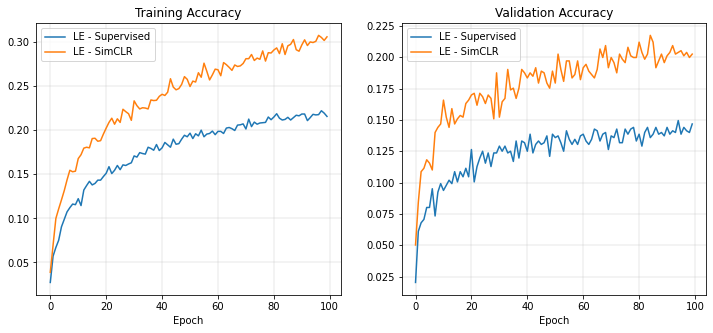

In [49]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=False)

ax[0].plot(le_sv['metrics_dict'][0]['train_acc'], label='LE - Supervised')
ax[0].plot(le_ssl['metrics_dict'][0]['train_acc'], label='LE - SimCLR')

ax[0].legend()
ax[0].grid(linewidth=0.3)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(le_sv['metrics_dict'][0]['valid_acc'], label='LE - Supervised')
ax[1].plot(le_ssl['metrics_dict'][0]['valid_acc'], label='LE - SimCLR')

ax[1].legend()
ax[1].grid(linewidth=0.3)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')

Text(0.5, 0, 'Epoch')

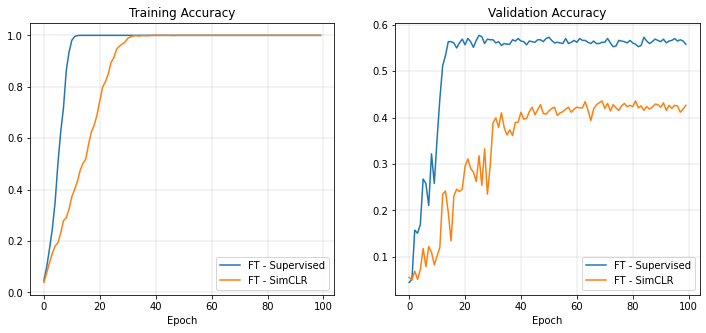

In [50]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=False)

# ax[0].plot(ft_rand['metrics_dict'][0]['train_acc'][:100], label='FT - Random Init')
ax[0].plot(ft_sv['metrics_dict'][0]['train_acc'], label='FT - Supervised')
ax[0].plot(ft_ssl['metrics_dict'][0]['train_acc'], label='FT - SimCLR')

ax[0].legend()
ax[0].grid(linewidth=0.3)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epoch')

# ax[1].plot(ft_rand['metrics_dict'][0]['valid_acc'][:100], label='FT - Random Init')
ax[1].plot(ft_sv['metrics_dict'][0]['valid_acc'], label='FT - Supervised')
ax[1].plot(ft_ssl['metrics_dict'][0]['valid_acc'], label='FT - SimCLR')

ax[1].legend()
ax[1].grid(linewidth=0.3)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')